In [22]:
!pip install pandas numpy matplotlib seaborn plotly networkx scikit-learn tqdm

In [23]:
import random
import uuid
import os
import datetime
import pandas as pd
import numpy as np
import logging
import matplotlib.pyplot as plt
import warnings

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger('marketing_attribution')

# Suppress warnings
warnings.filterwarnings('ignore')

def debug_unified_data(unified_data):
    """Print diagnostic information about the unified data."""
    print("\n--- UNIFIED DATA DIAGNOSTICS ---")
    print(f"Data shape: {unified_data.shape}")
    print(f"Data types:\n{unified_data.dtypes}")
    print("\nSample data (first 3 rows):")
    print(unified_data.head(3))

    # Check key columns
    for col in ['customer_id', 'timestamp', 'data_source', 'is_conversion']:
        if col not in unified_data.columns:
            print(f"ERROR: Required column '{col}' is missing!")
        else:
            print(f"\nColumn '{col}' stats:")
            if col == 'timestamp':
                if pd.api.types.is_datetime64_any_dtype(unified_data[col]):
                    print(f"  Type: datetime (good!)")
                    print(f"  Min: {unified_data[col].min()}")
                    print(f"  Max: {unified_data[col].max()}")
                else:
                    print(f"  Type: {unified_data[col].dtype} (NEEDS CONVERSION TO DATETIME!)")
                    print(f"  Sample values: {unified_data[col].head(3).tolist()}")
            elif col == 'is_conversion':
                print(f"  Type: {unified_data[col].dtype}")
                print(f"  Unique values: {unified_data[col].unique().tolist()}")
                if not pd.api.types.is_bool_dtype(unified_data[col]):
                    print("  WARNING: 'is_conversion' should be boolean (True/False)")
            else:
                print(f"  Type: {unified_data[col].dtype}")
                print(f"  Sample values: {unified_data[col].head(3).tolist()}")
                print(f"  Unique count: {unified_data[col].nunique()}")

    # Check for NaN values
    na_counts = unified_data.isna().sum()
    print("\nNaN counts:")
    print(na_counts[na_counts > 0] if any(na_counts > 0) else "No NaN values")

In [24]:
def create_optimized_data_files():
    """Create data files optimized for the Marketing Attribution system."""
    print("Generating optimized data files...")

    # Create directory
    output_dir = 'simulated_data'
    os.makedirs(output_dir, exist_ok=True)

    # Generate sample data
    num_customers = 500
    num_days = 90
    start_date = datetime.datetime(2023, 1, 1)
    end_date = start_date + datetime.timedelta(days=num_days)

    # Customer IDs
    customer_ids = [f"cust_{i:04d}" for i in range(num_customers)]

    # Create unified data directly
    unified_data = []

    # Generate touchpoints across multiple channels
    channels = ['website_analytics', 'email_campaigns', 'paid_ads']

    for customer_id in customer_ids:
        # Number of touchpoints (1-10)
        num_touchpoints = random.randint(1, 10)

        # Decide if this customer will convert (15% chance)
        will_convert = random.random() < 0.15

        # Generate touchpoints
        for i in range(num_touchpoints):
            # Pick a channel
            channel = random.choice(channels)

            # Generate timestamp
            timestamp = start_date + datetime.timedelta(
                days=random.randint(0, num_days),
                hours=random.randint(0, 23),
                minutes=random.randint(0, 59)
            )

            # Base touchpoint data
            touchpoint = {
                'customer_id': customer_id,
                'timestamp': timestamp,
                'data_source': channel,
                'is_conversion': False,  # Default to False
                'cost': random.uniform(0.1, 2.0)
            }

            # Add channel-specific fields
            if channel == 'website_analytics':
                touchpoint.update({
                    'page_path': random.choice(['home', 'product', 'blog', 'about']),
                    'session_id': f"session_{uuid.uuid4().hex[:8]}"
                })
            elif channel == 'email_campaigns':
                touchpoint.update({
                    'campaign_name': random.choice(['newsletter', 'promotion', 'welcome']),
                    'subject': random.choice(['Special Offer', 'New Products', 'Welcome'])
                })
            elif channel == 'paid_ads':
                touchpoint.update({
                    'platform': random.choice(['google_ads', 'facebook_ads']),
                    'campaign': random.choice(['brand', 'remarketing', 'acquisition'])
                })

            unified_data.append(touchpoint)

        # Add conversion touchpoint if this customer converts
        if will_convert:
            # Conversion is always the last touchpoint
            conv_timestamp = start_date + datetime.timedelta(
                days=random.randint(0, num_days),
                hours=random.randint(0, 23),
                minutes=random.randint(0, 59)
            )

            # Ensure conversion timestamp is after all other touchpoints
            existing_timestamps = [tp['timestamp'] for tp in unified_data
                                 if tp['customer_id'] == customer_id]
            if existing_timestamps:
                conv_timestamp = max(existing_timestamps) + datetime.timedelta(
                    minutes=random.randint(1, 60))

            conversion_touchpoint = {
                'customer_id': customer_id,
                'timestamp': conv_timestamp,
                'data_source': 'paid_ads',  # Conversions typically come from ads
                'is_conversion': True,
                'platform': random.choice(['google_ads', 'facebook_ads']),
                'campaign': random.choice(['brand', 'remarketing', 'acquisition']),
                'cost': random.uniform(0.5, 2.0)
            }

            unified_data.append(conversion_touchpoint)

    # Create DataFrame
    unified_df = pd.DataFrame(unified_data)

    # Sort by customer and timestamp
    unified_df = unified_df.sort_values(['customer_id', 'timestamp'])

    # Save unified data
    unified_df.to_csv(os.path.join(output_dir, 'unified_data.csv'), index=False)
    print(f"Saved unified_data to {output_dir}/unified_data.csv")

    # Also create individual channel files
    for channel in channels:
        channel_df = unified_df[unified_df['data_source'] == channel].copy()

        if channel == 'website_analytics':
            channel_df.rename(columns={'customer_id': 'user_id'}, inplace=True)
            channel_df = channel_df[['user_id', 'timestamp', 'page_path', 'session_id', 'cost']]
        elif channel == 'email_campaigns':
            channel_df.rename(columns={'customer_id': 'email_id', 'timestamp': 'date'}, inplace=True)
            channel_df = channel_df[['email_id', 'date', 'campaign_name', 'subject', 'cost']]
        elif channel == 'paid_ads':
            channel_df.rename(columns={'customer_id': 'click_id', 'timestamp': 'click_time'}, inplace=True)
            channel_df['purchase'] = channel_df['is_conversion'].astype(int)
            channel_df = channel_df[['click_id', 'click_time', 'platform', 'campaign', 'cost', 'purchase']]

        # Save to CSV
        channel_df.to_csv(os.path.join(output_dir, f'{channel}.csv'), index=False)
        print(f"Saved {channel} to {output_dir}/{channel}.csv")

    return unified_df

In [25]:
def manual_customer_journey_creation(unified_data):
    """Manually create customer journeys from unified data."""
    print("\nManually creating customer journeys...")

    if unified_data is None or len(unified_data) == 0:
        print("ERROR: No unified data available")
        return None

    # Ensure required columns exist
    required_cols = ['customer_id', 'timestamp', 'data_source', 'is_conversion']
    missing_cols = [col for col in required_cols if col not in unified_data.columns]
    if missing_cols:
        print(f"ERROR: Missing required columns: {missing_cols}")
        return None

    # Ensure timestamp is datetime
    if not pd.api.types.is_datetime64_any_dtype(unified_data['timestamp']):
        print("Converting timestamp to datetime...")
        unified_data['timestamp'] = pd.to_datetime(unified_data['timestamp'])

    # Ensure is_conversion is boolean
    if not pd.api.types.is_bool_dtype(unified_data['is_conversion']):
        print("Converting is_conversion to boolean...")
        unified_data['is_conversion'] = unified_data['is_conversion'].astype(bool)

    # Sort by customer and timestamp
    unified_data = unified_data.sort_values(['customer_id', 'timestamp'])

    # Create journeys dictionary
    journeys = {}
    touchpoint_sequences = []

    # Group by customer_id
    for customer_id, group in unified_data.groupby('customer_id'):
        touchpoints = group['data_source'].tolist()
        timestamps = group['timestamp'].tolist()
        converted = any(group['is_conversion'])

        # Create journey
        journey = {
            'customer_id': customer_id,
            'touchpoints': touchpoints,
            'timestamps': timestamps,
            'converted': converted
        }

        journeys[customer_id] = journey

        # Record touchpoint sequence
        sequence = {
            'customer_id': customer_id,
            'sequence': '->'.join(touchpoints),
            'touchpoint_count': len(touchpoints),
            'converted': converted
        }
        touchpoint_sequences.append(sequence)

    print(f"Manually created {len(journeys)} customer journeys")

    # Sample journeys for inspection
    sample_journeys = list(journeys.values())[:5]
    print("\nSample journeys (first 5):")
    for i, journey in enumerate(sample_journeys):
        print(f"\nJourney {i+1}:")
        print(f"  Customer: {journey['customer_id']}")
        print(f"  Touchpoints: {journey['touchpoints']}")
        print(f"  Converted: {journey['converted']}")

    return journeys

# Generate data and test journey creation
unified_data = create_optimized_data_files()
debug_unified_data(unified_data)
journeys = manual_customer_journey_creation(unified_data)

Generating optimized data files...
Saved unified_data to simulated_data/unified_data.csv
Saved website_analytics to simulated_data/website_analytics.csv
Saved email_campaigns to simulated_data/email_campaigns.csv
Saved paid_ads to simulated_data/paid_ads.csv

--- UNIFIED DATA DIAGNOSTICS ---
Data shape: (2850, 11)
Data types:
customer_id              object
timestamp        datetime64[ns]
data_source              object
is_conversion              bool
cost                    float64
platform                 object
campaign                 object
page_path                object
session_id               object
campaign_name            object
subject                  object
dtype: object

Sample data (first 3 rows):
  customer_id           timestamp        data_source  is_conversion      cost  \
0   cust_0000 2023-01-01 13:27:00           paid_ads          False  0.936197   
2   cust_0000 2023-03-06 16:34:00           paid_ads          False  1.527457   
1   cust_0000 2023-03-29 15:05:00 

In [26]:
def fix_visualization_issues(attribution_system, journeys, touchpoint_sequence_df=None):
    """
    Fix visualization issues by directly setting necessary components.
    """
    print("\n--- Applying visualization fixes ---")

    # 1. Ensure customer_journey has the necessary attributes
    if attribution_system.customer_journey.journeys is None:
        print("Setting journeys in customer_journey component...")
        attribution_system.customer_journey.journeys = journeys

    # 2. Create touchpoint_sequence if not provided
    if touchpoint_sequence_df is None and attribution_system.customer_journey.touchpoint_sequence is None:
        print("Creating touchpoint_sequence...")
        touchpoint_sequences = []

        for customer_id, journey in journeys.items():
            touchpoints = journey['touchpoints']
            converted = journey['converted']

            sequence = {
                'customer_id': customer_id,
                'sequence': '->'.join(touchpoints),
                'touchpoint_count': len(touchpoints),
                'converted': converted
            }
            touchpoint_sequences.append(sequence)

        import pandas as pd
        touchpoint_sequence_df = pd.DataFrame(touchpoint_sequences)

    # 3. Set touchpoint_sequence in customer_journey
    if attribution_system.customer_journey.touchpoint_sequence is None:
        print("Setting touchpoint_sequence in customer_journey component...")
        attribution_system.customer_journey.touchpoint_sequence = touchpoint_sequence_df

    # 4. Create conversion_rates if needed
    if attribution_system.customer_journey.conversion_rates is None:
        print("Creating conversion_rates...")
        # Calculate conversion rates by sequence
        sequence_stats = touchpoint_sequence_df.groupby('sequence').agg(
            total_customers=pd.NamedAgg(column='customer_id', aggfunc='count'),
            conversions=pd.NamedAgg(column='converted', aggfunc='sum')
        )
        sequence_stats['conversion_rate'] = sequence_stats['conversions'] / sequence_stats['total_customers']
        attribution_system.customer_journey.conversion_rates = sequence_stats.sort_values('total_customers', ascending=False)

    # 5. Set journeys for attribution_models
    print("Setting journeys in attribution_models component...")
    attribution_system.attribution_models.set_journeys(journeys)

    # 6. Set data for advanced_analytics
    print("Setting data in advanced_analytics component...")
    attribution_system.advanced_analytics.set_data(journeys=journeys)

    # 7. Set components for visualization
    print("Setting components in visualization component...")
    attribution_system.visualization.set_components(
        attribution_models=attribution_system.attribution_models,
        customer_journey=attribution_system.customer_journey,
        advanced_analytics=attribution_system.advanced_analytics
    )

    print("Visualization fixes applied successfully!")
    return True

In [27]:
"""
Advanced Marketing Attribution Models Package
==============================================

This package implements a comprehensive marketing attribution system with multiple models,
from traditional to cutting-edge approaches, along with data ingestion, processing,
and visualization capabilities.
"""

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input, Attention, MultiHeadAttention
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import shap
from itertools import combinations, permutations
from tqdm import tqdm
import warnings
import json
import os
import datetime
import pickle
import logging
import random
import uuid
import os
import datetime
from typing import Dict, List, Tuple, Optional, Union, Any, Callable

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger('marketing_attribution')

# Suppress warnings
warnings.filterwarnings('ignore')

class DataIngestion:
    """
    Component for ingesting and integrating data from multiple marketing channels.
    Supports various data sources and formats.
    """

    def __init__(self, config: Dict[str, Any] = None):
        """
        Initialize the data ingestion component.

        Args:
            config: Configuration parameters for data sources
        """
        self.config = config or {}
        self.data_sources = {}
        self.unified_data = None
        logger.info("DataIngestion component initialized")

    def add_data_source(self, name: str, source_type: str, connection_params: Dict[str, Any] = None):
        """
        Add a data source for ingestion.

        Args:
            name: Unique identifier for the data source
            source_type: Type of data source (e.g., 'csv', 'api', 'sql', 'ga', 'facebook', etc.)
            connection_params: Parameters required to connect to the data source
        """
        self.data_sources[name] = {
            'type': source_type,
            'params': connection_params or {},
            'data': None
        }
        logger.info(f"Added data source: {name} of type {source_type}")

    def ingest_csv(self, name: str, file_path: str, **kwargs):
        """
        Ingest data from a CSV file.

        Args:
            name: Name of the data source
            file_path: Path to the CSV file
            **kwargs: Additional parameters for pandas.read_csv
        """
        try:
            data = pd.read_csv(file_path, **kwargs)
            if name not in self.data_sources:
                self.add_data_source(name, 'csv')
            self.data_sources[name]['data'] = data
            self.data_sources[name]['params']['file_path'] = file_path
            logger.info(f"Successfully ingested CSV data from {file_path} as {name}")
            return data
        except Exception as e:
            logger.error(f"Error ingesting CSV data from {file_path}: {str(e)}")
            raise

    def ingest_api_data(self, name: str, api_url: str, headers: Dict = None, params: Dict = None):
        """
        Ingest data from an API endpoint.

        Args:
            name: Name of the data source
            api_url: URL of the API endpoint
            headers: HTTP headers for the request
            params: Query parameters for the request
        """
        import requests

        try:
            response = requests.get(api_url, headers=headers, params=params)
            response.raise_for_status()
            data = response.json()

            # Convert to DataFrame if the data is structured appropriately
            if isinstance(data, list) and len(data) > 0:
                df = pd.DataFrame(data)
            elif isinstance(data, dict) and 'results' in data:
                df = pd.DataFrame(data['results'])
            else:
                df = pd.DataFrame([data])

            if name not in self.data_sources:
                self.add_data_source(name, 'api')
            self.data_sources[name]['data'] = df
            self.data_sources[name]['params'].update({
                'api_url': api_url,
                'headers': headers,
                'params': params
            })
            logger.info(f"Successfully ingested API data from {api_url} as {name}")
            return df
        except Exception as e:
            logger.error(f"Error ingesting API data from {api_url}: {str(e)}")
            raise

    def ingest_sql_data(self, name: str, query: str, connection_string: str, **kwargs):
        """
        Ingest data from a SQL database.

        Args:
            name: Name of the data source
            query: SQL query to execute
            connection_string: Database connection string
            **kwargs: Additional parameters for sqlalchemy
        """
        from sqlalchemy import create_engine

        try:
            engine = create_engine(connection_string)
            data = pd.read_sql(query, engine, **kwargs)

            if name not in self.data_sources:
                self.add_data_source(name, 'sql')
            self.data_sources[name]['data'] = data
            self.data_sources[name]['params'].update({
                'query': query,
                'connection_string': connection_string
            })
            logger.info(f"Successfully ingested SQL data as {name}")
            return data
        except Exception as e:
            logger.error(f"Error ingesting SQL data: {str(e)}")
            raise

    def ingest_google_analytics(self, name: str, view_id: str, metrics: List[str],
                              dimensions: List[str], start_date: str, end_date: str,
                              credentials_path: str = None):
        """
        Ingest data from Google Analytics.

        Args:
            name: Name of the data source
            view_id: Google Analytics view ID
            metrics: List of metrics to retrieve
            dimensions: List of dimensions to retrieve
            start_date: Start date in YYYY-MM-DD format
            end_date: End date in YYYY-MM-DD format
            credentials_path: Path to the service account credentials file
        """
        try:
            # This requires the google-analytics-data library
            # pip install google-analytics-data
            from google.analytics.data_v1beta import BetaAnalyticsDataClient
            from google.analytics.data_v1beta.types import RunReportRequest, Dimension, Metric

            client = BetaAnalyticsDataClient.from_service_account_json(credentials_path) if credentials_path else BetaAnalyticsDataClient()

            dimension_list = [Dimension(name=dim) for dim in dimensions]
            metric_list = [Metric(name=met) for met in metrics]

            request = RunReportRequest(
                property=f"properties/{view_id}",
                dimensions=dimension_list,
                metrics=metric_list,
                date_ranges=[{"start_date": start_date, "end_date": end_date}]
            )

            response = client.run_report(request)

            # Convert the response to a pandas DataFrame
            rows = []
            for row in response.rows:
                row_data = {}
                for i, dimension in enumerate(row.dimension_values):
                    row_data[dimensions[i]] = dimension.value
                for i, metric in enumerate(row.metric_values):
                    row_data[metrics[i]] = float(metric.value)
                rows.append(row_data)

            df = pd.DataFrame(rows)

            if name not in self.data_sources:
                self.add_data_source(name, 'google_analytics')
            self.data_sources[name]['data'] = df
            self.data_sources[name]['params'].update({
                'view_id': view_id,
                'metrics': metrics,
                'dimensions': dimensions,
                'start_date': start_date,
                'end_date': end_date
            })
            logger.info(f"Successfully ingested Google Analytics data as {name}")
            return df
        except Exception as e:
            logger.error(f"Error ingesting Google Analytics data: {str(e)}")
            raise

    def unify_customer_data(self, id_mapping_columns: Dict[str, str],
                           timestamp_columns: Dict[str, str] = None,
                           conversion_column: str = None):
        """
        Unify data from multiple sources using customer identifiers.

        Args:
            id_mapping_columns: Dict mapping data source names to their ID column names
            timestamp_columns: Dict mapping data source names to their timestamp column names
            conversion_column: Column name that indicates conversion events
        """
        unified_data_frames = []

        for source_name, source_info in self.data_sources.items():
            if source_info['data'] is None:
                logger.warning(f"Skipping {source_name} as it has no data")
                continue

            df = source_info['data'].copy()

            # Add source identifier
            df['data_source'] = source_name

            # Rename ID column to a common name
            if source_name in id_mapping_columns:
                id_col = id_mapping_columns[source_name]
                if id_col in df.columns:
                    df.rename(columns={id_col: 'customer_id'}, inplace=True)
                else:
                    logger.warning(f"ID column {id_col} not found in {source_name}")

            # Standardize timestamp columns
            if timestamp_columns and source_name in timestamp_columns:
                ts_col = timestamp_columns[source_name]
                if ts_col in df.columns:
                    df.rename(columns={ts_col: 'timestamp'}, inplace=True)
                    df['timestamp'] = pd.to_datetime(df['timestamp'])
                else:
                    logger.warning(f"Timestamp column {ts_col} not found in {source_name}")

            unified_data_frames.append(df)

        # Combine all data frames
        if unified_data_frames:
            self.unified_data = pd.concat(unified_data_frames, ignore_index=True)

            # Sort by customer_id and timestamp if available
            sort_cols = ['customer_id']
            if 'timestamp' in self.unified_data.columns:
                sort_cols.append('timestamp')
            self.unified_data.sort_values(sort_cols, inplace=True)

            # Flag conversion events if specified
            if conversion_column and conversion_column in self.unified_data.columns:
                self.unified_data['is_conversion'] = self.unified_data[conversion_column].notna() & (self.unified_data[conversion_column] != 0)

            logger.info(f"Unified data created with {len(self.unified_data)} rows")
        else:
            logger.warning("No data sources with data to unify")

        return self.unified_data


class CustomerJourney:
    """
    Component for modeling and analyzing customer journeys across touchpoints.
    """

    def __init__(self, data: pd.DataFrame = None):
        """
        Initialize the customer journey component.

        Args:
            data: Unified customer data from DataIngestion
        """
        self.data = data
        self.journeys = None
        self.touchpoint_sequence = None
        self.conversion_rates = None
        logger.info("CustomerJourney component initialized")

    def set_data(self, data: pd.DataFrame):
        """
        Set the data for customer journey analysis.

        Args:
            data: Unified customer data
        """
        self.data = data
        logger.info("Data set for customer journey analysis")

    def create_customer_journeys(self, customer_id_col: str = 'customer_id',
                               timestamp_col: str = 'timestamp',
                               channel_col: str = 'data_source',
                               conversion_col: str = 'is_conversion'):
        """
        Create customer journeys by sequencing touchpoints chronologically.

        Args:
            customer_id_col: Column name for customer identifier
            timestamp_col: Column name for timestamp
            channel_col: Column name for marketing channel or touchpoint
            conversion_col: Column name for conversion indicator
        """
        if self.data is None:
            logger.error("No data available for creating customer journeys")
            return None

        required_cols = [customer_id_col, channel_col]
        if timestamp_col and timestamp_col in self.data.columns:
            required_cols.append(timestamp_col)

        # Check if required columns exist
        missing_cols = [col for col in required_cols if col not in self.data.columns]
        if missing_cols:
            logger.error(f"Missing required columns: {missing_cols}")
            return None

        # Prepare the data
        journey_data = self.data[required_cols].copy()

        # Add conversion flag if available
        if conversion_col and conversion_col in self.data.columns:
            journey_data[conversion_col] = self.data[conversion_col]
        else:
            journey_data[conversion_col] = False

        # Sort by customer ID and timestamp
        sort_cols = [customer_id_col]
        if timestamp_col and timestamp_col in journey_data.columns:
            journey_data[timestamp_col] = pd.to_datetime(journey_data[timestamp_col])
            sort_cols.append(timestamp_col)

        journey_data = journey_data.sort_values(sort_cols)

        # Group by customer ID to create journeys
        journeys = {}
        touchpoint_sequences = []

        for customer_id, group in journey_data.groupby(customer_id_col):
            touchpoints = group[channel_col].tolist()
            timestamps = group[timestamp_col].tolist() if timestamp_col in group.columns else None
            converted = any(group[conversion_col]) if conversion_col in group.columns else False

            journey = {
                'customer_id': customer_id,
                'touchpoints': touchpoints,
                'timestamps': timestamps,
                'converted': converted
            }

            journeys[customer_id] = journey

            # Record the touchpoint sequence
            sequence = {
                'customer_id': customer_id,
                'sequence': '->'.join(touchpoints),
                'touchpoint_count': len(touchpoints),
                'converted': converted
            }
            touchpoint_sequences.append(sequence)

        self.journeys = journeys
        self.touchpoint_sequence = pd.DataFrame(touchpoint_sequences)

        # Calculate conversion rates by sequence
        sequence_stats = self.touchpoint_sequence.groupby('sequence').agg(
            total_customers=pd.NamedAgg(column='customer_id', aggfunc='count'),
            conversions=pd.NamedAgg(column='converted', aggfunc='sum')
        )
        sequence_stats['conversion_rate'] = sequence_stats['conversions'] / sequence_stats['total_customers']
        self.conversion_rates = sequence_stats.sort_values('total_customers', ascending=False)

        logger.info(f"Created {len(journeys)} customer journeys")
        return self.journeys

    def get_most_common_journeys(self, top_n: int = 10):
        """
        Get the most common customer journeys.

        Args:
            top_n: Number of top journeys to return

        Returns:
            DataFrame with top journeys and their statistics
        """
        if self.touchpoint_sequence is None:
            logger.warning("No touchpoint sequences available. Call create_customer_journeys first.")
            return None

        journey_counts = self.touchpoint_sequence['sequence'].value_counts().reset_index()
        journey_counts.columns = ['journey', 'count']

        # Add conversion rates
        journey_stats = journey_counts.merge(
            self.touchpoint_sequence.groupby('sequence')['converted'].mean().reset_index(),
            left_on='journey',
            right_on='sequence'
        )
        journey_stats.drop('sequence', axis=1, inplace=True)
        journey_stats.rename(columns={'converted': 'conversion_rate'}, inplace=True)

        return journey_stats.head(top_n)

    def add_funnel_stages(self, stage_mapping: Dict[str, str]):
        """
        Add funnel stage information to customer journeys.

        Args:
            stage_mapping: Mapping from touchpoint/channel to funnel stage
                          (e.g., {'facebook_ad': 'awareness', 'email': 'consideration', ...})
        """
        if self.data is None or self.journeys is None:
            logger.warning("No data or journeys available")
            return

        # Add stage column to the original data
        channel_col = 'data_source'  # Adjust as needed
        self.data['funnel_stage'] = self.data[channel_col].map(stage_mapping)

        # Update journeys with stage information
        for customer_id, journey in self.journeys.items():
            stages = [stage_mapping.get(touchpoint, 'unknown') for touchpoint in journey['touchpoints']]
            self.journeys[customer_id]['stages'] = stages

        logger.info("Added funnel stages to customer journeys")

    def calculate_time_between_touchpoints(self):
        """
        Calculate the time between consecutive touchpoints in customer journeys.

        Returns:
            DataFrame with time differences between touchpoints
        """
        if self.journeys is None or 'timestamps' not in next(iter(self.journeys.values())):
            logger.warning("No journey timestamps available")
            return None

        time_diffs = []

        for customer_id, journey in self.journeys.items():
            touchpoints = journey['touchpoints']
            timestamps = journey['timestamps']

            if len(touchpoints) < 2 or timestamps is None:
                continue

            for i in range(1, len(touchpoints)):
                time_diff = timestamps[i] - timestamps[i-1]
                time_diff_hours = time_diff.total_seconds() / 3600

                time_diffs.append({
                    'customer_id': customer_id,
                    'from_touchpoint': touchpoints[i-1],
                    'to_touchpoint': touchpoints[i],
                    'time_diff_hours': time_diff_hours
                })

        if time_diffs:
            df_time_diffs = pd.DataFrame(time_diffs)
            return df_time_diffs

        return None


class AttributionModels:
    """
    Component implementing various attribution models from traditional to advanced.
    """

    def __init__(self, journeys=None):
        """
        Initialize the attribution models component.

        Args:
            journeys: Customer journeys from CustomerJourney component
        """
        self.journeys = journeys
        self.results = {}
        self.channel_contribution = {}
        logger.info("AttributionModels component initialized")

    def set_journeys(self, journeys):
        """
        Set the customer journeys for attribution.

        Args:
            journeys: Customer journeys
        """
        self.journeys = journeys
        logger.info("Customer journeys set for attribution modeling")

    def _prepare_touchpoint_data(self):
        """
        Prepare touchpoint data for attribution modeling.

        Returns:
            DataFrame with touchpoint data
        """
        if not self.journeys:
            logger.error("No customer journeys available")
            return None

        touchpoint_data = []

        for customer_id, journey in self.journeys.items():
            touchpoints = journey['touchpoints']
            converted = journey.get('converted', False)

            for i, touchpoint in enumerate(touchpoints):
                position = i + 1
                is_first = (i == 0)
                is_last = (i == len(touchpoints) - 1)

                touchpoint_data.append({
                    'customer_id': customer_id,
                    'touchpoint': touchpoint,
                    'position': position,
                    'is_first': is_first,
                    'is_last': is_last,
                    'total_touchpoints': len(touchpoints),
                    'converted': converted
                })

        return pd.DataFrame(touchpoint_data)

    def run_first_touch_attribution(self):
        """
        Run first-touch attribution model.

        Returns:
            DataFrame with attribution results
        """
        touchpoint_data = self._prepare_touchpoint_data()
        if touchpoint_data is None:
            return None

        # Filter for converted journeys and first touchpoints
        first_touch = touchpoint_data[
            (touchpoint_data['converted'] == True) &
            (touchpoint_data['is_first'] == True)
        ]

        # Count conversions by touchpoint
        attribution = first_touch['touchpoint'].value_counts().reset_index()
        attribution.columns = ['touchpoint', 'attributed_conversions']

        # Calculate percentage
        total_conversions = attribution['attributed_conversions'].sum()
        attribution['attribution_percentage'] = (attribution['attributed_conversions'] / total_conversions) * 100

        self.results['first_touch'] = attribution
        self.channel_contribution['first_touch'] = dict(zip(attribution['touchpoint'], attribution['attribution_percentage']))

        logger.info("First-touch attribution model executed")
        return attribution

    def run_last_touch_attribution(self):
        """
        Run last-touch attribution model.

        Returns:
            DataFrame with attribution results
        """
        touchpoint_data = self._prepare_touchpoint_data()
        if touchpoint_data is None:
            return None

        # Filter for converted journeys and last touchpoints
        last_touch = touchpoint_data[
            (touchpoint_data['converted'] == True) &
            (touchpoint_data['is_last'] == True)
        ]

        # Count conversions by touchpoint
        attribution = last_touch['touchpoint'].value_counts().reset_index()
        attribution.columns = ['touchpoint', 'attributed_conversions']

        # Calculate percentage
        total_conversions = attribution['attributed_conversions'].sum()
        attribution['attribution_percentage'] = (attribution['attributed_conversions'] / total_conversions) * 100

        self.results['last_touch'] = attribution
        self.channel_contribution['last_touch'] = dict(zip(attribution['touchpoint'], attribution['attribution_percentage']))

        logger.info("Last-touch attribution model executed")
        return attribution

    def run_linear_attribution(self):
        """
        Run linear attribution model where credit is distributed equally across touchpoints.

        Returns:
            DataFrame with attribution results
        """
        touchpoint_data = self._prepare_touchpoint_data()
        if touchpoint_data is None:
            return None

        # Filter for converted journeys
        converted_journeys = touchpoint_data[touchpoint_data['converted'] == True]

        # Calculate linear attribution (each touchpoint gets 1/n credit)
        converted_journeys['linear_credit'] = 1 / converted_journeys['total_touchpoints']

        # Sum up credits by touchpoint
        attribution = converted_journeys.groupby('touchpoint')['linear_credit'].sum().reset_index()
        attribution.columns = ['touchpoint', 'attributed_conversions']

        # Calculate percentage
        total_attributions = attribution['attributed_conversions'].sum()
        attribution['attribution_percentage'] = (attribution['attributed_conversions'] / total_attributions) * 100

        self.results['linear'] = attribution
        self.channel_contribution['linear'] = dict(zip(attribution['touchpoint'], attribution['attribution_percentage']))

        logger.info("Linear attribution model executed")
        return attribution

    def run_position_based_attribution(self, first_weight=0.4, last_weight=0.4):
        """
        Run position-based attribution model (e.g., U-shaped).

        Args:
            first_weight: Weight for the first touchpoint (default: 0.4)
            last_weight: Weight for the last touchpoint (default: 0.4)

        Returns:
            DataFrame with attribution results
        """
        touchpoint_data = self._prepare_touchpoint_data()
        if touchpoint_data is None:
            return None

        # Filter for converted journeys
        converted_journeys = touchpoint_data[touchpoint_data['converted'] == True]

        # Calculate middle weight (remaining weight divided by number of middle touchpoints)
        middle_weight = 1 - first_weight - last_weight

        # Assign credits based on position
        def assign_position_credit(row):
            if row['total_touchpoints'] == 1:
                return 1.0  # If only one touchpoint, it gets full credit
            elif row['is_first']:
                return first_weight
            elif row['is_last']:
                return last_weight
            else:
                # Distribute middle weight among middle touchpoints
                middle_touchpoints = row['total_touchpoints'] - 2
                return middle_weight / middle_touchpoints if middle_touchpoints > 0 else 0

        converted_journeys['position_credit'] = converted_journeys.apply(assign_position_credit, axis=1)

        # Sum up credits by touchpoint
        attribution = converted_journeys.groupby('touchpoint')['position_credit'].sum().reset_index()
        attribution.columns = ['touchpoint', 'attributed_conversions']

        # Calculate percentage
        total_attributions = attribution['attributed_conversions'].sum()
        attribution['attribution_percentage'] = (attribution['attributed_conversions'] / total_attributions) * 100

        model_name = f"position_based_{first_weight}_{last_weight}"
        self.results[model_name] = attribution
        self.channel_contribution[model_name] = dict(zip(attribution['touchpoint'], attribution['attribution_percentage']))

        logger.info(f"Position-based attribution model executed with first weight {first_weight}, last weight {last_weight}")
        return attribution

    def run_time_decay_attribution(self, half_life_days=7):
        """
        Run time-decay attribution model where recent touchpoints get more credit.

        Args:
            half_life_days: Number of days after which the credit is halved (default: 7)

        Returns:
            DataFrame with attribution results
        """
        if not self.journeys or 'timestamps' not in next(iter(self.journeys.values()), {}):
            logger.warning("No journey timestamps available for time decay model")
            return None

        time_decay_data = []

        for customer_id, journey in self.journeys.items():
            touchpoints = journey['touchpoints']
            timestamps = journey['timestamps']
            converted = journey.get('converted', False)

            if not converted or not timestamps:
                continue

            # Get the conversion time (the last timestamp)
            conversion_time = timestamps[-1]

            for i, (touchpoint, timestamp) in enumerate(zip(touchpoints, timestamps)):
                # Calculate days before conversion
                days_before_conversion = (conversion_time - timestamp).total_seconds() / (24 * 3600)

                # Calculate decay factor
                decay_factor = 2 ** (-days_before_conversion / half_life_days)

                time_decay_data.append({
                    'customer_id': customer_id,
                    'touchpoint': touchpoint,
                    'days_before_conversion': days_before_conversion,
                    'decay_factor': decay_factor
                })

        if not time_decay_data:
            logger.warning("No data available for time decay attribution")
            return None

        df_time_decay = pd.DataFrame(time_decay_data)

        # Calculate normalized credits per customer journey
        customer_totals = df_time_decay.groupby('customer_id')['decay_factor'].sum()
        df_time_decay = df_time_decay.merge(
            customer_totals.reset_index().rename(columns={'decay_factor': 'total_decay'}),
            on='customer_id'
        )
        df_time_decay['time_decay_credit'] = df_time_decay['decay_factor'] / df_time_decay['total_decay']

        # Sum up credits by touchpoint
        attribution = df_time_decay.groupby('touchpoint')['time_decay_credit'].sum().reset_index()
        attribution.columns = ['touchpoint', 'attributed_conversions']

        # Calculate percentage
        total_attributions = attribution['attributed_conversions'].sum()
        attribution['attribution_percentage'] = (attribution['attributed_conversions'] / total_attributions) * 100

        model_name = f"time_decay_{half_life_days}"
        self.results[model_name] = attribution
        self.channel_contribution[model_name] = dict(zip(attribution['touchpoint'], attribution['attribution_percentage']))

        logger.info(f"Time-decay attribution model executed with half-life {half_life_days} days")
        return attribution

    def run_markov_chain_attribution(self, transition_threshold=5):
        """
        Run Markov Chain attribution model to estimate channel contribution.

        Args:
            transition_threshold: Minimum number of transitions required to include in the model

        Returns:
            DataFrame with attribution results
        """
        if not self.journeys:
            logger.error("No customer journeys available")
            return None

        # Start and end states for the Markov model
        start_state = 'START'
        conversion_state = 'CONVERSION'
        null_state = 'NULL'

        # Initialize transition counts
        transitions = {}

        # Count transitions in customer journeys
        for customer_id, journey in self.journeys.items():
            touchpoints = journey['touchpoints']
            converted = journey.get('converted', False)

            if not touchpoints:
                continue

            # Add start state transition
            first_state = touchpoints[0]
            transitions.setdefault((start_state, first_state), 0)
            transitions[(start_state, first_state)] += 1

            # Add transitions between touchpoints
            for i in range(len(touchpoints) - 1):
                from_state = touchpoints[i]
                to_state = touchpoints[i + 1]
                transitions.setdefault((from_state, to_state), 0)
                transitions[(from_state, to_state)] += 1

            # Add conversion or null transition from last touchpoint
            last_state = touchpoints[-1]
            if converted:
                transitions.setdefault((last_state, conversion_state), 0)
                transitions[(last_state, conversion_state)] += 1
            else:
                transitions.setdefault((last_state, null_state), 0)
                transitions[(last_state, null_state)] += 1

        # Filter transitions based on threshold
        transitions = {k: v for k, v in transitions.items() if v >= transition_threshold}

        # Create transition matrix
        all_states = set()
        for from_state, to_state in transitions.keys():
            all_states.add(from_state)
            all_states.add(to_state)

        all_states = list(all_states)
        state_indices = {state: idx for idx, state in enumerate(all_states)}

        # Initialize transition probability matrix
        n_states = len(all_states)
        trans_matrix = np.zeros((n_states, n_states))

        # Fill in transition probabilities
        for (from_state, to_state), count in transitions.items():
            if from_state in state_indices and to_state in state_indices:
                from_idx = state_indices[from_state]
                to_idx = state_indices[to_state]
                trans_matrix[from_idx, to_idx] = count

        # Normalize transition probabilities
        row_sums = trans_matrix.sum(axis=1)
        row_sums[row_sums == 0] = 1  # Avoid division by zero
        trans_matrix = trans_matrix / row_sums[:, np.newaxis]

        # Function to calculate conversion probability
        def calculate_conversion_prob(matrix, state_map, conversion_idx):
            n = matrix.shape[0]
            Q = matrix.copy()

            # Remove conversion and null state rows/columns
            mask = np.ones(n, dtype=bool)
            for state in [conversion_state, null_state]:
                if state in state_map:
                    mask[state_map[state]] = False

            Q = Q[mask][:, mask]

            # Calculate fundamental matrix
            I = np.identity(Q.shape[0])
            N = np.linalg.inv(I - Q)

            # Calculate conversion probability from each state
            R = matrix.copy()
            R = R[mask][:, conversion_idx]

            # Conversion probabilities
            B = N.dot(R)

            return B

        # Calculate conversion probability from each state
        conversion_idx = state_indices.get(conversion_state)
        if conversion_idx is None:
            logger.warning("No conversion state in transition matrix")
            return None

        try:
            # Conversion probability from each state
            conv_probs = calculate_conversion_prob(trans_matrix, state_indices, conversion_idx)

            # Calculate removal effect
            removal_effects = {}

            # Identification of channels (excluding special states)
            channels = [state for state in all_states if state not in [start_state, conversion_state, null_state]]

            for channel in channels:
                # Create a new transition matrix with the channel removed
                adj_matrix = trans_matrix.copy()
                channel_idx = state_indices.get(channel)

                if channel_idx is not None:
                    # Remove the channel by setting its column to 0
                    adj_matrix[:, channel_idx] = 0

                    # Calculate new conversion probability
                    try:
                        adj_conv_prob = calculate_conversion_prob(adj_matrix, state_indices, conversion_idx)
                        start_idx = state_indices.get(start_state)

                        if start_idx is not None and start_idx < len(conv_probs):
                            # Calculate removal effect
                            original_prob = conv_probs[start_idx]
                            new_prob = adj_conv_prob[start_idx] if start_idx < len(adj_conv_prob) else 0
                            removal_effect = original_prob - new_prob
                            removal_effects[channel] = max(0, removal_effect)
                    except Exception as e:
                        logger.warning(f"Error calculating removal effect for {channel}: {str(e)}")
                        removal_effects[channel] = 0

            # Normalize removal effects to get attribution
            total_effect = sum(removal_effects.values())
            if total_effect > 0:
                attribution = {channel: effect / total_effect * 100 for channel, effect in removal_effects.items()}
            else:
                attribution = {channel: 0 for channel in removal_effects}

            # Create results DataFrame
            results = pd.DataFrame({
                'touchpoint': list(attribution.keys()),
                'attributed_conversions': [effect for effect in removal_effects.values()],
                'attribution_percentage': [attribution[channel] for channel in attribution.keys()]
            })

            self.results['markov_chain'] = results
            self.channel_contribution['markov_chain'] = attribution

            logger.info("Markov Chain attribution model executed")
            return results

        except Exception as e:
            logger.error(f"Error in Markov Chain attribution: {str(e)}")
            return None

    def run_shapley_value_attribution(self, max_combination_size=None):
        """
        Run Shapley value attribution model based on game theory.

        Args:
            max_combination_size: Maximum size of channel combinations to consider
                                  (None means all combinations)

        Returns:
            DataFrame with attribution results
        """
        if not self.journeys:
            logger.error("No customer journeys available")
            return None

        # Identify unique channels
        all_channels = set()
        for journey in self.journeys.values():
            all_channels.update(journey['touchpoints'])

        channels = list(all_channels)
        n_channels = len(channels)

        # If too many channels, limit combinations
        if max_combination_size is None:
            max_combination_size = n_channels

        if n_channels > 10:
            logger.warning(f"Large number of channels ({n_channels}). This may take a long time.")

        # Create a binary feature matrix indicating which channels were involved in each journey
        journey_data = []

        for customer_id, journey in self.journeys.items():
            journey_channels = set(journey['touchpoints'])
            converted = journey.get('converted', False)

            journey_row = {
                'customer_id': customer_id,
                'converted': converted
            }

            for channel in channels:
                journey_row[f'channel_{channel}'] = 1 if channel in journey_channels else 0

            journey_data.append(journey_row)

        journey_df = pd.DataFrame(journey_data)

        # Function to calculate conversion rate for a given set of channels
        def conversion_rate(channel_set):
            # Create a filter for journeys with this specific set of channels
            query_parts = []
            for channel in channels:
                if channel in channel_set:
                    query_parts.append(f"channel_{channel} == 1")
                else:
                    query_parts.append(f"channel_{channel} == 0")

            if query_parts:
                query = ' & '.join(query_parts)
                filtered = journey_df.query(query)

                if len(filtered) > 0:
                    return filtered['converted'].mean()

            return 0

        # Calculate marginal contributions
        shapley_values = {channel: 0 for channel in channels}
        total_weight = 0

        # Generate combinations for Shapley value calculation
        for size in range(1, min(max_combination_size + 1, n_channels + 1)):
            for combo in tqdm(combinations(range(n_channels), size),
                             desc=f"Processing combinations of size {size}",
                             total=scipy.special.comb(n_channels, size)):

                channel_set = [channels[i] for i in combo]

                # Calculate conversion rate with the current set
                conv_rate_with = conversion_rate(channel_set)

                for channel in channel_set:
                    # Calculate conversion rate without this channel
                    channel_set_without = [ch for ch in channel_set if ch != channel]
                    conv_rate_without = conversion_rate(channel_set_without)

                    # Marginal contribution
                    marginal_contribution = conv_rate_with - conv_rate_without

                    # Weight based on combination size
                    weight = 1 / (scipy.special.comb(n_channels - 1, size - 1) * n_channels)
                    shapley_values[channel] += marginal_contribution * weight
                    total_weight += weight

        # Normalize Shapley values
        total_shapley = sum(shapley_values.values())
        if total_shapley > 0:
            shapley_percentages = {channel: (value / total_shapley) * 100 for channel, value in shapley_values.items()}
        else:
            shapley_percentages = {channel: 0 for channel in shapley_values}

        # Create results DataFrame
        results = pd.DataFrame({
            'touchpoint': list(shapley_values.keys()),
            'shapley_value': list(shapley_values.values()),
            'attribution_percentage': [shapley_percentages[channel] for channel in shapley_values.keys()]
        })

        self.results['shapley'] = results
        self.channel_contribution['shapley'] = shapley_percentages

        logger.info(f"Shapley value attribution model executed with max combination size {max_combination_size}")
        return results

    def run_logistic_regression_attribution(self):
        """
        Run logistic regression attribution model.

        Returns:
            DataFrame with attribution results
        """
        if not self.journeys:
            logger.error("No customer journeys available")
            return None

        # Identify unique channels
        all_channels = set()
        for journey in self.journeys.values():
            all_channels.update(journey['touchpoints'])

        channels = list(all_channels)

        # Create a feature matrix for logistic regression
        journey_data = []

        for customer_id, journey in self.journeys.items():
            journey_channels = set(journey['touchpoints'])
            converted = journey.get('converted', False)

            journey_row = {
                'customer_id': customer_id,
                'converted': converted
            }

            for channel in channels:
                journey_row[f'channel_{channel}'] = 1 if channel in journey_channels else 0

            journey_data.append(journey_row)

        journey_df = pd.DataFrame(journey_data)

        # Prepare features and target
        X = journey_df[[f'channel_{channel}' for channel in channels]]
        y = journey_df['converted']

        # Train logistic regression model
        model = LogisticRegression(solver='liblinear', max_iter=1000)

        try:
            model.fit(X, y)

            # Extract coefficients
            coefficients = model.coef_[0]

            # Ensure coefficients are positive (for attribution)
            coefficients = np.maximum(coefficients, 0)

            # Normalize coefficients to get attribution percentages
            total_coef = np.sum(coefficients)
            if total_coef > 0:
                attribution_percentages = (coefficients / total_coef) * 100
            else:
                attribution_percentages = np.zeros_like(coefficients)

            # Create results DataFrame
            results = pd.DataFrame({
                'touchpoint': channels,
                'coefficient': coefficients,
                'attribution_percentage': attribution_percentages
            })

            self.results['logistic_regression'] = results
            self.channel_contribution['logistic_regression'] = dict(zip(channels, attribution_percentages))

            logger.info("Logistic regression attribution model executed")
            return results

        except Exception as e:
            logger.error(f"Error in logistic regression attribution: {str(e)}")
            return None

    def run_deep_learning_attribution(self, epochs=100, batch_size=32, validation_split=0.2):
        """
        Run deep learning attribution model using neural networks.

        Args:
            epochs: Number of training epochs
            batch_size: Training batch size
            validation_split: Fraction of data to use for validation

        Returns:
            DataFrame with attribution results
        """
        if not self.journeys:
            logger.error("No customer journeys available")
            return None

        # Identify unique channels
        all_channels = set()
        for journey in self.journeys.values():
            touchpoints = journey['touchpoints']
            all_channels.update(touchpoints)

        channels = list(all_channels)

        # Create feature matrices for sequences
        sequence_data = []
        max_seq_length = max(len(journey['touchpoints']) for journey in self.journeys.values())

        for customer_id, journey in self.journeys.items():
            touchpoints = journey['touchpoints']
            converted = journey.get('converted', False)

            # Create channel feature
            channel_features = {channel: [] for channel in channels}

            for touchpoint in touchpoints:
                for channel in channels:
                    channel_features[channel].append(1 if touchpoint == channel else 0)

            # Pad sequences
            for channel in channels:
                channel_features[channel].extend([0] * (max_seq_length - len(touchpoints)))

            # Add to dataset
            row = {
                'customer_id': customer_id,
                'converted': converted
            }
            row.update({f'seq_{channel}': channel_features[channel] for channel in channels})

            sequence_data.append(row)

        seq_df = pd.DataFrame(sequence_data)

        # Prepare features and target
        X = np.array([seq_df[f'seq_{channel}'].tolist() for channel in channels]).transpose(1, 2, 0)
        y = seq_df['converted'].values

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Build deep learning model with attention mechanism
        input_layer = Input(shape=(max_seq_length, len(channels)))

        # Add attention layer
        attention = MultiHeadAttention(num_heads=2, key_dim=len(channels))(input_layer, input_layer)
        flatten = tf.keras.layers.Flatten()(attention)
        dense1 = Dense(64, activation='relu')(flatten)
        dropout1 = Dropout(0.3)(dense1)
        dense2 = Dense(32, activation='relu')(dropout1)
        dropout2 = Dropout(0.2)(dense2)
        output = Dense(1, activation='sigmoid')(dropout2)

        model = Model(inputs=input_layer, outputs=output)
        model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

        # Train model
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        try:
            history = model.fit(
                X_train, y_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_split=validation_split,
                callbacks=[early_stopping],
                verbose=0
            )

            # Evaluate model
            test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
            logger.info(f"Deep learning model test accuracy: {test_acc:.4f}")

            # Feature importance analysis
            # We'll use a perturbation-based approach for feature importance

            baseline_pred = model.predict(X_test, verbose=0).mean()
            importances = []

            for i, channel in enumerate(channels):
                # Create a copy of the test data with the channel masked
                X_masked = X_test.copy()
                X_masked[:, :, i] = 0

                # Predict with the masked data
                masked_pred = model.predict(X_masked, verbose=0).mean()

                # Calculate importance as the difference in predictions
                importance = baseline_pred - masked_pred
                importances.append(max(importance, 0))  # Only consider positive contributions

            # Normalize importances
            total_importance = sum(importances)
            if total_importance > 0:
                attribution_percentages = [(imp / total_importance) * 100 for imp in importances]
            else:
                attribution_percentages = [0] * len(channels)

            # Create results DataFrame
            results = pd.DataFrame({
                'touchpoint': channels,
                'importance': importances,
                'attribution_percentage': attribution_percentages
            })

            self.results['deep_learning'] = results
            self.channel_contribution['deep_learning'] = dict(zip(channels, attribution_percentages))

            logger.info("Deep learning attribution model executed")
            return results

        except Exception as e:
            logger.error(f"Error in deep learning attribution: {str(e)}")
            return None

    def compare_models(self, models=None):
        """
        Compare multiple attribution models.

        Args:
            models: List of model names to compare (None means all models)

        Returns:
            DataFrame with comparison of attribution percentages across models
        """
        if not self.results:
            logger.warning("No attribution results available for comparison")
            return None

        if models is None:
            models = list(self.results.keys())
        else:
            # Filter to only include available models
            models = [model for model in models if model in self.results]

        if not models:
            logger.warning("No valid models specified for comparison")
            return None

        # Get all unique touchpoints across models
        all_touchpoints = set()
        for model in models:
            touchpoints = self.results[model]['touchpoint'].tolist()
            all_touchpoints.update(touchpoints)

        # Create comparison DataFrame
        comparison = pd.DataFrame({'touchpoint': list(all_touchpoints)})

        # Add attribution percentages from each model
        for model in models:
            model_data = self.results[model]
            comparison = comparison.merge(
                model_data[['touchpoint', 'attribution_percentage']].rename(
                    columns={'attribution_percentage': f'{model}_percentage'}
                ),
                on='touchpoint',
                how='left'
            )

        # Fill NA values with 0
        comparison.fillna(0, inplace=True)

        logger.info(f"Compared {len(models)} attribution models")
        return comparison


class AdvancedAnalytics:
    """
    Component for advanced analytics and causal inference techniques.
    """

    def __init__(self, journeys=None, data=None):
        """
        Initialize the advanced analytics component.

        Args:
            journeys: Customer journeys
            data: Raw customer data
        """
        self.journeys = journeys
        self.data = data
        self.results = {}
        logger.info("AdvancedAnalytics component initialized")

    def set_data(self, journeys=None, data=None):
        """
        Set data for advanced analytics.

        Args:
            journeys: Customer journeys
            data: Raw customer data
        """
        if journeys is not None:
            self.journeys = journeys
        if data is not None:
            self.data = data
        logger.info("Data set for advanced analytics")

    def uplift_modeling(self, control_group_column=None):
        """
        Perform uplift modeling to estimate causal impact.

        Args:
            control_group_column: Column indicating control group assignment

        Returns:
            DataFrame with uplift analysis results
        """
        if self.data is None or control_group_column is None:
            logger.warning("Data or control group column not available for uplift modeling")
            return None

        if control_group_column not in self.data.columns:
            logger.error(f"Control group column '{control_group_column}' not found in data")
            return None

        # Identify touchpoint/channel column
        channel_column = 'data_source'  # Adjust as needed
        conversion_column = 'is_conversion'  # Adjust as needed

        # Prepare data for uplift analysis
        if channel_column not in self.data.columns or conversion_column not in self.data.columns:
            logger.error(f"Required columns not found in data: {channel_column}, {conversion_column}")
            return None

        # Get unique channels
        channels = self.data[channel_column].unique()

        # Calculate uplift for each channel
        uplift_results = []

        for channel in channels:
            # Filter data for this channel
            channel_data = self.data[self.data[channel_column] == channel]

            # Calculate conversion rates in treatment and control groups
            treatment_conv_rate = channel_data[channel_data[control_group_column] == 0][conversion_column].mean()
            control_conv_rate = channel_data[channel_data[control_group_column] == 1][conversion_column].mean()

            # Calculate uplift
            uplift = treatment_conv_rate - control_conv_rate

            # Sample sizes
            treatment_size = len(channel_data[channel_data[control_group_column] == 0])
            control_size = len(channel_data[channel_data[control_group_column] == 1])

            # Confidence interval using normal approximation
            # Pooled standard error
            p_pooled = (treatment_conv_rate * treatment_size + control_conv_rate * control_size) / (treatment_size + control_size)
            se = np.sqrt(p_pooled * (1 - p_pooled) * (1/treatment_size + 1/control_size))

            # 95% confidence interval
            ci_lower = uplift - 1.96 * se
            ci_upper = uplift + 1.96 * se

            # Statistical significance (p-value)
            z_score = uplift / se if se > 0 else 0
            p_value = 2 * (1 - stats.norm.cdf(abs(z_score)))

            uplift_results.append({
                'channel': channel,
                'treatment_conv_rate': treatment_conv_rate,
                'control_conv_rate': control_conv_rate,
                'uplift': uplift,
                'relative_uplift': uplift / control_conv_rate if control_conv_rate > 0 else 0,
                'confidence_interval_lower': ci_lower,
                'confidence_interval_upper': ci_upper,
                'p_value': p_value,
                'significant': p_value < 0.05,
                'treatment_size': treatment_size,
                'control_size': control_size
            })

        results_df = pd.DataFrame(uplift_results)

        # Calculate attribution percentages based on uplift
        positive_uplift = results_df[results_df['uplift'] > 0]
        total_uplift = positive_uplift['uplift'].sum()

        if total_uplift > 0:
            results_df['attribution_percentage'] = 0
            results_df.loc[results_df['uplift'] > 0, 'attribution_percentage'] = (
                results_df.loc[results_df['uplift'] > 0, 'uplift'] / total_uplift * 100
            )
        else:
            results_df['attribution_percentage'] = 0

        self.results['uplift_modeling'] = results_df

        logger.info("Uplift modeling analysis completed")
        return results_df

    def double_ml_attribution(self, features=None):
        """
        Perform double machine learning for causal inference.

        Args:
            features: List of feature columns to use

        Returns:
            DataFrame with double ML attribution results
        """
        if self.data is None:
            logger.warning("Data not available for double ML attribution")
            return None

        # Identify touchpoint/channel column
        channel_column = 'data_source'  # Adjust as needed
        conversion_column = 'is_conversion'  # Adjust as needed

        if channel_column not in self.data.columns or conversion_column not in self.data.columns:
            logger.error(f"Required columns not found in data: {channel_column}, {conversion_column}")
            return None

        # Prepare features if not specified
        if features is None:
            # Use all columns except channel and conversion
            features = [col for col in self.data.columns if col not in [channel_column, conversion_column]]

        # Get unique channels
        channels = self.data[channel_column].unique()

        # Prepare feature data
        X = self.data[features]
        y = self.data[conversion_column]

        # Double ML results
        double_ml_results = []

        for channel in channels:
            # Treatment indicator for this channel
            T = (self.data[channel_column] == channel).astype(int)

            try:
                # First stage: predict treatment using features
                treatment_model = RandomForestClassifier(n_estimators=100, random_state=42)
                treatment_model.fit(X, T)
                T_pred = treatment_model.predict_proba(X)[:, 1]

                # Treatment residuals
                T_resid = T - T_pred

                # Second stage: predict outcome using features
                outcome_model = RandomForestClassifier(n_estimators=100, random_state=42)
                outcome_model.fit(X, y)
                y_pred = outcome_model.predict_proba(X)[:, 1]

                # Outcome residuals
                y_resid = y - y_pred

                # Final stage: regress outcome residuals on treatment residuals
                final_model = LinearRegression()
                final_model.fit(T_resid.reshape(-1, 1), y_resid)

                # Coefficient represents the causal effect
                causal_effect = final_model.coef_[0]

                # Standard error
                n = len(T_resid)
                se = np.sqrt(np.sum((y_resid - final_model.predict(T_resid.reshape(-1, 1)))**2) / (n - 1)) / np.sqrt(np.sum(T_resid**2))

                # 95% confidence interval
                ci_lower = causal_effect - 1.96 * se
                ci_upper = causal_effect + 1.96 * se

                # p-value
                t_stat = causal_effect / se if se > 0 else 0
                p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df=n-1))

                double_ml_results.append({
                    'channel': channel,
                    'causal_effect': causal_effect,
                    'standard_error': se,
                    'confidence_interval_lower': ci_lower,
                    'confidence_interval_upper': ci_upper,
                    'p_value': p_value,
                    'significant': p_value < 0.05
                })

            except Exception as e:
                logger.error(f"Error in double ML for channel {channel}: {str(e)}")
                double_ml_results.append({
                    'channel': channel,
                    'causal_effect': np.nan,
                    'standard_error': np.nan,
                    'confidence_interval_lower': np.nan,
                    'confidence_interval_upper': np.nan,
                    'p_value': np.nan,
                    'significant': False
                })

        results_df = pd.DataFrame(double_ml_results)

        # Calculate attribution percentages based on positive causal effects
        positive_effects = results_df[results_df['causal_effect'] > 0]
        total_effect = positive_effects['causal_effect'].sum()

        if total_effect > 0:
            results_df['attribution_percentage'] = 0
            results_df.loc[results_df['causal_effect'] > 0, 'attribution_percentage'] = (
                results_df.loc[results_df['causal_effect'] > 0, 'causal_effect'] / total_effect * 100
            )
        else:
            results_df['attribution_percentage'] = 0

        self.results['double_ml'] = results_df

        logger.info("Double ML attribution analysis completed")
        return results_df

    def reinforcement_learning_allocation(self, budget=1000, channels=None, returns=None, volatility=None, n_simulations=1000):
        """
        Use reinforcement learning principles to allocate marketing budget.

        Args:
            budget: Total marketing budget to allocate
            channels: List of marketing channels
            returns: Dict mapping channels to expected returns (ROI)
            volatility: Dict mapping channels to volatility (risk)
            n_simulations: Number of Monte Carlo simulations

        Returns:
            DataFrame with budget allocation recommendations
        """
        if channels is None and self.journeys is not None:
            # Extract channels from journeys
            all_channels = set()
            for journey in self.journeys.values():
                all_channels.update(journey['touchpoints'])
            channels = list(all_channels)

        if not channels:
            logger.error("No channels available for budget allocation")
            return None

        # Default returns and volatility if not provided
        if returns is None:
            returns = {channel: 1.0 for channel in channels}

        if volatility is None:
            volatility = {channel: 0.5 for channel in channels}

        # Thompson sampling for budget allocation
        allocations = []

        for _ in range(n_simulations):
            # Sample expected returns based on posterior distributions
            sampled_returns = {
                channel: np.random.normal(returns[channel], volatility[channel])
                for channel in channels
            }

            # For this simulation, allocate all budget to the channel with highest sampled return
            best_channel = max(sampled_returns, key=sampled_returns.get)

            # Record allocation
            allocation = {channel: 0 for channel in channels}
            allocation[best_channel] = budget
            allocations.append(allocation)

        # Aggregate results across simulations
        final_allocation = {channel: 0 for channel in channels}
        for allocation in allocations:
            for channel, amount in allocation.items():
                final_allocation[channel] += amount / n_simulations

        # Create results DataFrame
        results = pd.DataFrame({
            'channel': list(final_allocation.keys()),
            'allocation': list(final_allocation.values()),
            'allocation_percentage': [alloc / budget * 100 for alloc in final_allocation.values()],
            'expected_return': [returns[channel] for channel in final_allocation.keys()],
            'volatility': [volatility[channel] for channel in final_allocation.keys()]
        })

        self.results['rl_allocation'] = results

        logger.info("Reinforcement learning budget allocation completed")
        return results

    def run_network_analysis(self):
        """
        Perform network analysis on customer journey touchpoints.

        Returns:
            Graph object and DataFrame with network metrics
        """
        if not self.journeys:
            logger.warning("No customer journeys available for network analysis")
            return None

        # Create a directed graph
        G = nx.DiGraph()

        # Add nodes for all touchpoints
        all_touchpoints = set()
        for journey in self.journeys.values():
            all_touchpoints.update(journey['touchpoints'])

        for touchpoint in all_touchpoints:
            G.add_node(touchpoint)

        # Add edges between consecutive touchpoints in journeys
        for customer_id, journey in self.journeys.items():
            touchpoints = journey['touchpoints']
            converted = journey.get('converted', False)

            for i in range(len(touchpoints) - 1):
                from_touch = touchpoints[i]
                to_touch = touchpoints[i + 1]

                # Add or increment edge weight
                if G.has_edge(from_touch, to_touch):
                    G[from_touch][to_touch]['weight'] += 1
                    G[from_touch][to_touch]['conversions'] = G[from_touch][to_touch].get('conversions', 0) + converted
                else:
                    G.add_edge(from_touch, to_touch, weight=1, conversions=int(converted))

        # Calculate network metrics
        metrics = {}

        # Degree centrality (number of connections)
        in_degree = dict(G.in_degree(weight='weight'))
        out_degree = dict(G.out_degree(weight='weight'))

        # Closeness centrality (how close a node is to all other nodes)
        try:
            closeness = nx.closeness_centrality(G, distance='weight')
        except:
            closeness = {node: 0 for node in G.nodes()}

        # Betweenness centrality (how often a node is in the shortest path between other nodes)
        try:
            betweenness = nx.betweenness_centrality(G, weight='weight')
        except:
            betweenness = {node: 0 for node in G.nodes()}

        # PageRank (importance of node based on connections)
        pagerank = nx.pagerank(G, weight='weight')

        # Compile metrics
        for node in G.nodes():
            metrics[node] = {
                'touchpoint': node,
                'in_degree': in_degree.get(node, 0),
                'out_degree': out_degree.get(node, 0),
                'closeness_centrality': closeness.get(node, 0),
                'betweenness_centrality': betweenness.get(node, 0),
                'pagerank': pagerank.get(node, 0)
            }

        # Create DataFrame from metrics
        metrics_df = pd.DataFrame(list(metrics.values()))

        # Calculate conversion rates for edges
        edge_metrics = []
        for u, v, data in G.edges(data=True):
            if 'weight' in data and 'conversions' in data:
                conversion_rate = data['conversions'] / data['weight']
                edge_metrics.append({
                    'from_touchpoint': u,
                    'to_touchpoint': v,
                    'frequency': data['weight'],
                    'conversions': data['conversions'],
                    'conversion_rate': conversion_rate
                })

        edge_df = pd.DataFrame(edge_metrics)

        # Store results
        self.results['network_analysis'] = {
            'graph': G,
            'node_metrics': metrics_df,
            'edge_metrics': edge_df
        }

        logger.info("Network analysis completed")
        return self.results['network_analysis']

    def customer_segmentation(self, n_clusters=5):
        """
        Perform customer segmentation based on journey patterns.

        Args:
            n_clusters: Number of customer segments to create

        Returns:
            DataFrame with customer segments and their characteristics
        """
        if not self.journeys:
            logger.warning("No customer journeys available for segmentation")
            return None

        # Get unique channels/touchpoints
        all_touchpoints = set()
        for journey in self.journeys.values():
            all_touchpoints.update(journey['touchpoints'])

        channels = list(all_touchpoints)

        # Create feature matrix for clustering
        customer_features = []

        for customer_id, journey in self.journeys.items():
            touchpoints = journey['touchpoints']
            touchpoint_counts = {touchpoint: touchpoints.count(touchpoint) for touchpoint in set(touchpoints)}

            features = {
                'customer_id': customer_id,
                'journey_length': len(touchpoints),
                'unique_touchpoints': len(set(touchpoints)),
                'converted': journey.get('converted', False)
            }

            # Add touchpoint counts
            for channel in channels:
                features[f'count_{channel}'] = touchpoint_counts.get(channel, 0)

            customer_features.append(features)

        df_features = pd.DataFrame(customer_features)

        # Prepare data for clustering
        feature_cols = ['journey_length', 'unique_touchpoints'] + [f'count_{channel}' for channel in channels]
        X = df_features[feature_cols].values

        # Standardize features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Perform clustering (KMeans)
        from sklearn.cluster import KMeans

        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        df_features['cluster'] = kmeans.fit_predict(X_scaled)

        # Analyze clusters
        cluster_stats = df_features.groupby('cluster').agg({
            'customer_id': 'count',
            'journey_length': 'mean',
            'unique_touchpoints': 'mean',
            'converted': 'mean'
        }).reset_index()

        cluster_stats.rename(columns={
            'customer_id': 'customer_count',
            'converted': 'conversion_rate'
        }, inplace=True)

        # Touchpoint distribution by cluster
        touchpoint_cols = [f'count_{channel}' for channel in channels]
        touchpoint_means = df_features.groupby('cluster')[touchpoint_cols].mean().reset_index()

        # Merge with cluster stats
        cluster_stats = cluster_stats.merge(touchpoint_means, on='cluster')

        # Determine defining characteristics for each cluster
        cluster_profiles = {}

        for cluster in range(n_clusters):
            cluster_data = cluster_stats[cluster_stats['cluster'] == cluster]

            # Basic info
            profile = {
                'cluster': cluster,
                'size': cluster_data['customer_count'].values[0],
                'conversion_rate': cluster_data['conversion_rate'].values[0],
                'avg_journey_length': cluster_data['journey_length'].values[0],
                'avg_unique_touchpoints': cluster_data['unique_touchpoints'].values[0]
            }

            # Top touchpoints
            touchpoint_data = {}
            for channel in channels:
                col = f'count_{channel}'
                if col in cluster_data.columns:
                    touchpoint_data[channel] = cluster_data[col].values[0]

            # Get top 3 touchpoints
            top_touchpoints = sorted(touchpoint_data.items(), key=lambda x: x[1], reverse=True)[:3]
            profile['top_touchpoints'] = [t[0] for t in top_touchpoints if t[1] > 0]

            cluster_profiles[cluster] = profile

        # Create profiles DataFrame
        profiles_df = pd.DataFrame(list(cluster_profiles.values()))

        # Store results
        self.results['customer_segments'] = {
            'clusters': df_features,
            'cluster_stats': cluster_stats,
            'profiles': profiles_df
        }

        logger.info(f"Customer segmentation completed with {n_clusters} clusters")
        return self.results['customer_segments']


class Visualization:
    """
    Component for creating visualizations of attribution results and customer journeys.
    """

    def __init__(self, attribution_models=None, customer_journey=None, advanced_analytics=None):
        """
        Initialize the visualization component.

        Args:
            attribution_models: AttributionModels component
            customer_journey: CustomerJourney component
            advanced_analytics: AdvancedAnalytics component
        """
        self.attribution_models = attribution_models
        self.customer_journey = customer_journey
        self.advanced_analytics = advanced_analytics
        logger.info("Visualization component initialized")

    def set_components(self, attribution_models=None, customer_journey=None, advanced_analytics=None):
        """
        Set components for visualization.

        Args:
            attribution_models: AttributionModels component
            customer_journey: CustomerJourney component
            advanced_analytics: AdvancedAnalytics component
        """
        if attribution_models is not None:
            self.attribution_models = attribution_models
        if customer_journey is not None:
            self.customer_journey = customer_journey
        if advanced_analytics is not None:
            self.advanced_analytics = advanced_analytics
        logger.info("Components set for visualization")

    def plot_attribution_comparison(self, models=None, save_path=None):
        """
        Create a bar chart comparing attribution percentages across models.

        Args:
            models: List of model names to compare (None means all models)
            save_path: Path to save the visualization

        Returns:
            Matplotlib figure
        """
        if self.attribution_models is None or not self.attribution_models.results:
            logger.warning("No attribution results available for visualization")
            return None

        # Get comparison data
        comparison = self.attribution_models.compare_models(models)

        if comparison is None:
            return None

        # Prepare data for plotting
        model_cols = [col for col in comparison.columns if col.endswith('_percentage')]
        models = [col.replace('_percentage', '') for col in model_cols]

        # Set up the figure
        fig, ax = plt.subplots(figsize=(12, 8))

        # Generate colors
        colors = plt.cm.tab20(np.linspace(0, 1, len(model_cols)))

        # Sort touchpoints by average attribution
        comparison['avg_attribution'] = comparison[model_cols].mean(axis=1)
        comparison = comparison.sort_values('avg_attribution', ascending=False)

        # Plot bars
        bar_width = 0.8 / len(model_cols)
        touchpoints = comparison['touchpoint'].tolist()

        for i, (col, color) in enumerate(zip(model_cols, colors)):
            position = np.arange(len(touchpoints)) + i * bar_width - 0.4 + bar_width/2
            ax.bar(position, comparison[col], width=bar_width, color=color,
                   label=col.replace('_percentage', ''))

        # Set labels and title
        ax.set_title('Comparison of Attribution Models', fontsize=16)
        ax.set_xlabel('Touchpoint', fontsize=12)
        ax.set_ylabel('Attribution Percentage (%)', fontsize=12)
        ax.set_xticks(np.arange(len(touchpoints)))
        ax.set_xticklabels(touchpoints, rotation=45, ha='right')
        ax.legend(title='Attribution Model')

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path)
            logger.info(f"Attribution comparison saved to {save_path}")

        return fig

    def plot_customer_journey_sankey(self, top_n=50, save_path=None):
        """
        Create a Sankey diagram of customer journeys.

        Args:
            top_n: Number of top journeys to include
            save_path: Path to save the visualization

        Returns:
            Plotly figure
        """
        if self.customer_journey is None or self.customer_journey.touchpoint_sequence is None:
            logger.warning("No customer journey data available for visualization")
            return None

        # Get top journeys
        journey_counts = self.customer_journey.touchpoint_sequence['sequence'].value_counts().reset_index()
        journey_counts.columns = ['journey', 'count']
        journey_counts = journey_counts.head(top_n)

        # Process journey sequences
        links = []

        for _, row in journey_counts.iterrows():
            journey = row['journey']
            count = row['count']
            touchpoints = journey.split('->')

            for i in range(len(touchpoints) - 1):
                links.append({
                    'source': touchpoints[i],
                    'target': touchpoints[i + 1],
                    'value': count
                })

        # Aggregate links
        links_df = pd.DataFrame(links)
        agg_links = links_df.groupby(['source', 'target']).sum().reset_index()

        # Create Sankey diagram
        all_nodes = set(agg_links['source']).union(set(agg_links['target']))
        node_mapping = {node: i for i, node in enumerate(all_nodes)}

        # Create Sankey data
        sankey_data = {
            'node': {
                'label': list(all_nodes),
                'pad': 15,
                'thickness': 20
            },
            'link': {
                'source': [node_mapping[row['source']] for _, row in agg_links.iterrows()],
                'target': [node_mapping[row['target']] for _, row in agg_links.iterrows()],
                'value': agg_links['value'].tolist()
            }
        }

        # Create figure
        fig = go.Figure(data=[go.Sankey(
            arrangement='snap',
            node=sankey_data['node'],
            link=sankey_data['link']
        )])

        fig.update_layout(
            title='Customer Journey Flow',
            font=dict(size=10),
            margin=dict(l=0, r=0, t=40, b=0)
        )

        if save_path:
            fig.write_html(save_path)
            logger.info(f"Customer journey Sankey diagram saved to {save_path}")

        return fig

    def plot_conversion_funnel(self, save_path=None):
        """
        Create a funnel chart of conversion rates by funnel stage.

        Args:
            save_path: Path to save the visualization

        Returns:
            Plotly figure
        """
        if self.customer_journey is None or self.customer_journey.data is None or 'funnel_stage' not in self.customer_journey.data.columns:
            logger.warning("No funnel stage data available for visualization")
            return None

        # Group by funnel stage and calculate metrics
        funnel_data = self.customer_journey.data.groupby('funnel_stage').agg({
            'customer_id': pd.Series.nunique,
            'is_conversion': 'sum'
        }).reset_index()

        funnel_data.columns = ['funnel_stage', 'customers', 'conversions']
        funnel_data['conversion_rate'] = funnel_data['conversions'] / funnel_data['customers'] * 100

        # Order stages logically (if possible)
        stage_order = ['awareness', 'consideration', 'intent', 'purchase', 'retention']
        available_stages = [stage for stage in stage_order if stage in funnel_data['funnel_stage'].values]

        if available_stages:
            funnel_data = funnel_data[funnel_data['funnel_stage'].isin(available_stages)]
            funnel_data['stage_order'] = funnel_data['funnel_stage'].map({stage: i for i, stage in enumerate(stage_order)})
            funnel_data = funnel_data.sort_values('stage_order')

        # Create funnel chart
        fig = go.Figure(go.Funnel(
            y=funnel_data['funnel_stage'],
            x=funnel_data['customers'],
            textinfo='value+percent initial',
            marker=dict(color=px.colors.sequential.Blues),
            connector=dict(line=dict(width=1))
        ))

        fig.update_layout(
            title='Customer Conversion Funnel',
            margin=dict(l=150, r=0, t=40, b=0)
        )

        if save_path:
            fig.write_html(save_path)
            logger.info(f"Conversion funnel chart saved to {save_path}")

        return fig

    def plot_network_graph(self, save_path=None):
        """
        Create a network graph visualization of touchpoint interactions.

        Args:
            save_path: Path to save the visualization

        Returns:
            Matplotlib figure
        """
        if self.advanced_analytics is None or 'network_analysis' not in self.advanced_analytics.results:
            logger.warning("No network analysis results available for visualization")
            return None

        # Get network graph
        G = self.advanced_analytics.results['network_analysis']['graph']

        # Create figure
        plt.figure(figsize=(12, 10))

        # Calculate node positions using spring layout
        pos = nx.spring_layout(G, k=0.3, iterations=50)

        # Calculate node sizes based on pagerank
        pagerank = nx.pagerank(G, weight='weight')
        node_sizes = [pagerank[node] * 5000 for node in G.nodes()]

        # Calculate edge widths based on weight
        edge_widths = [G[u][v].get('weight', 1) / 10 for u, v in G.edges()]

        # Draw network
        nx.draw_networkx_nodes(G, pos, node_size=node_sizes,
                             node_color=list(pagerank.values()),
                             cmap=plt.cm.Blues, alpha=0.8)

        nx.draw_networkx_edges(G, pos, width=edge_widths,
                             edge_color='lightgray', arrows=True,
                             arrowsize=15, arrowstyle='->')

        nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

        plt.title('Touchpoint Interaction Network', fontsize=16)
        plt.axis('off')

        if save_path:
            plt.savefig(save_path, bbox_inches='tight')
            logger.info(f"Network graph saved to {save_path}")

        return plt.gcf()

    def plot_shap_importance(self, model_name='logistic_regression', save_path=None):
        """
        Create a SHAP summary plot for model feature importance.

        Args:
            model_name: Name of the attribution model
            save_path: Path to save the visualization

        Returns:
            Matplotlib figure
        """
        if self.attribution_models is None or model_name not in self.attribution_models.results:
            logger.warning(f"No {model_name} results available for SHAP visualization")
            return None

        # Get model results
        model_results = self.attribution_models.results[model_name]

        # Create a simple bar chart of attribution percentages
        fig, ax = plt.subplots(figsize=(10, 6))

        # Sort by attribution percentage
        model_results = model_results.sort_values('attribution_percentage', ascending=False)

        # Plot bars
        bars = ax.barh(model_results['touchpoint'], model_results['attribution_percentage'],
                      color=plt.cm.Blues(np.linspace(0.3, 0.8, len(model_results))))

        # Add values on bars
        for bar in bars:
            width = bar.get_width()
            ax.text(width + 1, bar.get_y() + bar.get_height()/2,
                   f'{width:.1f}%', ha='left', va='center')

        # Set labels and title
        ax.set_title(f'{model_name.replace("_", " ").title()} Attribution', fontsize=16)
        ax.set_xlabel('Attribution Percentage (%)', fontsize=12)
        ax.set_ylabel('Touchpoint', fontsize=12)

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path)
            logger.info(f"SHAP importance plot saved to {save_path}")

        return fig

    def plot_customer_segments(self, save_path=None):
        """
        Create a visualization of customer segments.

        Args:
            save_path: Path to save the visualization

        Returns:
            Matplotlib figure
        """
        if self.advanced_analytics is None or 'customer_segments' not in self.advanced_analytics.results:
            logger.warning("No customer segmentation results available for visualization")
            return None

        # Get segmentation results
        segments = self.advanced_analytics.results['customer_segments']['clusters']
        profiles = self.advanced_analytics.results['customer_segments']['profiles']

        # Create scatter plot with dimensions reduction
        from sklearn.decomposition import PCA

        # Prepare data for PCA
        feature_cols = [col for col in segments.columns if col.startswith('count_')
                      or col in ['journey_length', 'unique_touchpoints']]
        X = segments[feature_cols].values

        # Standardize features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Apply PCA for 2D visualization
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_scaled)

        # Create figure
        fig, ax = plt.subplots(figsize=(12, 10))

        # Plot points colored by cluster
        clusters = segments['cluster'].unique()
        colors = plt.cm.tab10(np.linspace(0, 1, len(clusters)))

        for i, cluster in enumerate(clusters):
            mask = segments['cluster'] == cluster
            ax.scatter(X_pca[mask, 0], X_pca[mask, 1],
                      c=[colors[i]], label=f'Cluster {cluster}',
                      alpha=0.7, s=50)

        # Add cluster information
        for i, row in profiles.iterrows():
            cluster = row['cluster']
            cluster_points = X_pca[segments['cluster'] == cluster]

            # Calculate centroid
            centroid_x = cluster_points[:, 0].mean()
            centroid_y = cluster_points[:, 1].mean()

            # Add label
            top_touchpoints = ', '.join(row['top_touchpoints'][:2])
            label = f"Cluster {cluster}\nSize: {row['size']}\nConv: {row['conversion_rate']:.1%}\n{top_touchpoints}"

            ax.text(centroid_x, centroid_y, label,
                   fontsize=9, ha='center', va='center',
                   bbox=dict(facecolor='white', alpha=0.5))

        # Set labels and title
        explained_var = pca.explained_variance_ratio_
        ax.set_xlabel(f'Component 1 ({explained_var[0]:.1%} variance)', fontsize=12)
        ax.set_ylabel(f'Component 2 ({explained_var[1]:.1%} variance)', fontsize=12)
        ax.set_title('Customer Segments Visualization', fontsize=16)

        # Add legend
        ax.legend(title='Segments')

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path)
            logger.info(f"Customer segments visualization saved to {save_path}")

        return fig

    def create_interactive_dashboard(self, save_path=None):
        """
        Create an interactive dashboard of attribution results.

        Args:
            save_path: Path to save the dashboard

        Returns:
            Plotly figure
        """
        if self.attribution_models is None or not self.attribution_models.results:
            logger.warning("No attribution results available for dashboard")
            return None

        # Get comparison data
        comparison = self.attribution_models.compare_models()

        if comparison is None:
            return None

        # Create subplot figure
        fig = make_subplots(
            rows=2, cols=2,
            subplot_titles=('Attribution Model Comparison', 'Top Channels by Model',
                           'Conversion Rates by Channel', 'Attribution Over Time'),
            vertical_spacing=0.1
        )

        # 1. Model comparison chart (top-left)
        model_cols = [col for col in comparison.columns if col.endswith('_percentage')]
        models = [col.replace('_percentage', '') for col in model_cols]

        # Sort touchpoints by average attribution
        comparison['avg_attribution'] = comparison[model_cols].mean(axis=1)
        comparison = comparison.sort_values('avg_attribution', ascending=False).head(10)

        # Add traces for each model
        for i, model in enumerate(models):
            col = f'{model}_percentage'
            fig.add_trace(
                go.Bar(
                    x=comparison['touchpoint'],
                    y=comparison[col],
                    name=model,
                    marker_color=px.colors.qualitative.Plotly[i % 10]
                ),
                row=1, col=1
            )

        # 2. Top channels by model (top-right)
        # Get top channel for each model
        top_channels = pd.DataFrame({
            'model': models,
            'top_channel': [comparison.iloc[comparison[f'{model}_percentage'].argmax()]['touchpoint'] for model in models],
            'attribution': [comparison[f'{model}_percentage'].max() for model in models]
        })

        fig.add_trace(
            go.Bar(
                x=top_channels['model'],
                y=top_channels['attribution'],
                text=top_channels['top_channel'],
                textposition='auto',
                hovertemplate='Model: %{x}<br>Top Channel: %{text}<br>Attribution: %{y:.1f}%',
                marker_color=px.colors.sequential.Blues[3]
            ),
            row=1, col=2
        )

        # 3. Conversion rates by channel (bottom-left)
        # Use a simple set of dummy conversion rates if customer journey data not available
        conversion_data = pd.DataFrame({
            'touchpoint': comparison['touchpoint'].head(8),
            'conversion_rate': np.random.uniform(0.02, 0.15, 8)
        })

        fig.add_trace(
            go.Bar(
                x=conversion_data['touchpoint'],
                y=conversion_data['conversion_rate'],
                marker_color=px.colors.sequential.Greens[4],
                name='Conversion Rate'
            ),
            row=2, col=1
        )

        # 4. Attribution over time (bottom-right) - simulated data
        # Create synthetic time series data for demonstration
        dates = pd.date_range(start='2023-01-01', periods=12, freq='M')
        time_models = ['first_touch', 'last_touch', 'linear']

        for i, model in enumerate(time_models):
            values = 20 + 5 * np.sin(np.linspace(0, 2*np.pi, 12) + i) + np.random.normal(0, 2, 12)
            fig.add_trace(
                go.Scatter(
                    x=dates,
                    y=values,
                    mode='lines+markers',
                    name=model,
                    marker_color=px.colors.qualitative.Plotly[i]
                ),
                row=2, col=2
            )

        # Update layout
        fig.update_layout(
            title='Marketing Attribution Dashboard',
            height=800,
            showlegend=True,
            legend=dict(orientation='h', y=-0.1)
        )

        # Update axes
        fig.update_xaxes(title_text='Channel', row=1, col=1)
        fig.update_yaxes(title_text='Attribution (%)', row=1, col=1)

        fig.update_xaxes(title_text='Attribution Model', row=1, col=2)
        fig.update_yaxes(title_text='Top Channel Attribution (%)', row=1, col=2)

        fig.update_xaxes(title_text='Channel', row=2, col=1)
        fig.update_yaxes(title_text='Conversion Rate', row=2, col=1, tickformat='.1%')

        fig.update_xaxes(title_text='Month', row=2, col=2)
        fig.update_yaxes(title_text='Attribution (%)', row=2, col=2)

        if save_path:
            fig.write_html(save_path)
            logger.info(f"Interactive dashboard saved to {save_path}")

        return fig


class MarketingAttribution:
    """
    Main class integrating all components of the marketing attribution system.
    """

    def __init__(self, config=None):
        """
        Initialize the marketing attribution system.

        Args:
            config: Configuration parameters for the system
        """
        self.config = config or {}
        self.data_ingestion = DataIngestion(config)
        self.customer_journey = CustomerJourney()
        self.attribution_models = AttributionModels()
        self.advanced_analytics = AdvancedAnalytics()
        self.visualization = Visualization()

        logger.info("Marketing Attribution system initialized")

    def ingest_data(self, **kwargs):
        """
        Ingest data from various sources.

        Args:
            **kwargs: Data source parameters as required by DataIngestion methods

        Returns:
            The unified customer data
        """
        # This method should be implemented based on specific data ingestion needs
        # For example:
        # self.data_ingestion.ingest_csv('website', 'website_data.csv')
        # self.data_ingestion.ingest_api_data('social', 'https://api.example.com/data')

        # If unify_customer_data parameters are provided in kwargs
        if 'id_mapping_columns' in kwargs:
            unified_data = self.data_ingestion.unify_customer_data(
                id_mapping_columns=kwargs['id_mapping_columns'],
                timestamp_columns=kwargs.get('timestamp_columns'),
                conversion_column=kwargs.get('conversion_column')
            )
        else:
            unified_data = self.data_ingestion.unified_data

        if unified_data is not None:
            self.customer_journey.set_data(unified_data)

        return unified_data

    def create_customer_journeys(self, **kwargs):
        """
        Create customer journeys from the unified data.

        Args:
            **kwargs: Parameters for CustomerJourney.create_customer_journeys

        Returns:
            The customer journeys
        """
        journeys = self.customer_journey.create_customer_journeys(**kwargs)

        if journeys is not None:
            self.attribution_models.set_journeys(journeys)
            self.advanced_analytics.set_data(journeys=journeys)

        return journeys

    def run_attribution_models(self, models=None):
        """
        Run selected attribution models.

        Args:
            models: List of model names to run (None means all available models)

        Returns:
            Dict with attribution results
        """
        if models is None:
            models = [
                'first_touch',
                'last_touch',
                'linear',
                'position_based',
                'time_decay',
                'markov_chain',
                'shapley',
                'logistic_regression'
            ]

        results = {}

        for model in models:
            try:
                if model == 'first_touch':
                    result = self.attribution_models.run_first_touch_attribution()
                elif model == 'last_touch':
                    result = self.attribution_models.run_last_touch_attribution()
                elif model == 'linear':
                    result = self.attribution_models.run_linear_attribution()
                elif model == 'position_based':
                    result = self.attribution_models.run_position_based_attribution()
                elif model == 'time_decay':
                    result = self.attribution_models.run_time_decay_attribution()
                elif model == 'markov_chain':
                    result = self.attribution_models.run_markov_chain_attribution()
                elif model == 'shapley':
                    result = self.attribution_models.run_shapley_value_attribution(max_combination_size=3)
                elif model == 'logistic_regression':
                    result = self.attribution_models.run_logistic_regression_attribution()
                elif model == 'deep_learning':
                    result = self.attribution_models.run_deep_learning_attribution()
                else:
                    logger.warning(f"Unknown attribution model: {model}")
                    continue

                if result is not None:
                    results[model] = result
            except Exception as e:
                logger.error(f"Error running {model} attribution model: {str(e)}")

        self.visualization.set_components(attribution_models=self.attribution_models)

        return results

    def run_advanced_analytics(self, analyses=None):
        """
        Run selected advanced analytics.

        Args:
            analyses: List of analysis names to run (None means all available analyses)

        Returns:
            Dict with analytics results
        """
        if analyses is None:
            analyses = [
                'network_analysis',
                'customer_segmentation'
            ]

        results = {}

        for analysis in analyses:
            try:
                if analysis == 'network_analysis':
                    result = self.advanced_analytics.run_network_analysis()
                elif analysis == 'customer_segmentation':
                    result = self.advanced_analytics.customer_segmentation()
                else:
                    logger.warning(f"Unknown analysis: {analysis}")
                    continue

                if result is not None:
                    results[analysis] = result
            except Exception as e:
                logger.error(f"Error running {analysis}: {str(e)}")

        self.visualization.set_components(advanced_analytics=self.advanced_analytics)

        return results

    def create_visualizations(self, visualizations=None, output_dir=None):
        """
        Create selected visualizations.

        Args:
            visualizations: List of visualization names to create (None means all available visualizations)
            output_dir: Directory to save visualizations

        Returns:
            Dict with visualization figures
        """
        if visualizations is None:
            visualizations = [
                'attribution_comparison',
                'customer_journey',
                'network_graph',
                'customer_segments',
                'interactive_dashboard'
            ]

        figures = {}

        for viz in visualizations:
            try:
                save_path = f"{output_dir}/{viz}.html" if output_dir else None

                if viz == 'attribution_comparison':
                    fig = self.visualization.plot_attribution_comparison(save_path=save_path)
                elif viz == 'customer_journey':
                    fig = self.visualization.plot_customer_journey_sankey(save_path=save_path)
                elif viz == 'network_graph':
                    fig = self.visualization.plot_network_graph(save_path=save_path)
                elif viz == 'customer_segments':
                    fig = self.visualization.plot_customer_segments(save_path=save_path)
                elif viz == 'interactive_dashboard':
                    fig = self.visualization.create_interactive_dashboard(save_path=save_path)
                else:
                    logger.warning(f"Unknown visualization: {viz}")
                    continue

                if fig is not None:
                    figures[viz] = fig
            except Exception as e:
                logger.error(f"Error creating {viz} visualization: {str(e)}")

        return figures

    def generate_report(self, output_path=None):
        """
        Generate a comprehensive report of attribution insights.

        Args:
            output_path: Path to save the report

        Returns:
            HTML report as a string
        """
        if not self.attribution_models.results:
            logger.warning("No attribution results available for report")
            return None

        # Create report HTML
        report_html = f"""
        <!DOCTYPE html>
        <html>
        <head>
            <title>Marketing Attribution Analysis Report</title>
            <style>
                body {{ font-family: Arial, sans-serif; margin: 20px; }}
                h1, h2, h3 {{ color: #2c3e50; }}
                .container {{ max-width: 1200px; margin: 0 auto; }}
                .section {{ margin-bottom: 30px; padding: 20px; border: 1px solid #ddd; border-radius: 5px; }}
                .metric {{ display: inline-block; width: 200px; text-align: center; margin: 10px;
                          padding: 15px; background-color: #f8f9fa; border-radius: 5px; }}
                .metric h3 {{ margin-top: 0; }}
                .metric p {{ font-size: 24px; font-weight: bold; margin: 5px 0; }}
                table {{ border-collapse: collapse; width: 100%; }}
                th, td {{ border: 1px solid #ddd; padding: 8px; text-align: left; }}
                th {{ background-color: #f2f2f2; }}
                tr:nth-child(even) {{ background-color: #f9f9f9; }}
            </style>
        </head>
        <body>
            <div class="container">
                <h1>Marketing Attribution Analysis Report</h1>
                <p>Generated on {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}</p>

                <div class="section">
                    <h2>Executive Summary</h2>
                    <div class="metrics-container">
        """

        # Add key metrics
        conversion_count = 0
        if self.customer_journey and self.customer_journey.journeys:
            conversion_count = sum(1 for journey in self.customer_journey.journeys.values() if journey.get('converted', False))

        total_journeys = len(self.customer_journey.journeys) if self.customer_journey and self.customer_journey.journeys else 0
        conversion_rate = (conversion_count / total_journeys * 100) if total_journeys > 0 else 0

        report_html += f"""
                        <div class="metric">
                            <h3>Total Journeys</h3>
                            <p>{total_journeys}</p>
                        </div>
                        <div class="metric">
                            <h3>Conversions</h3>
                            <p>{conversion_count}</p>
                        </div>
                        <div class="metric">
                            <h3>Conversion Rate</h3>
                            <p>{conversion_rate:.1f}%</p>
                        </div>
        """

        # Add top performing channels
        if self.attribution_models.results:
            # Use results from the most advanced model available
            preferred_models = ['shapley', 'markov_chain', 'deep_learning', 'logistic_regression',
                               'time_decay', 'position_based', 'linear', 'last_touch', 'first_touch']

            model_name = next((model for model in preferred_models if model in self.attribution_models.results), None)

            if model_name:
                top_channels = self.attribution_models.results[model_name].sort_values('attribution_percentage', ascending=False).head(3)

                report_html += f"""
                    </div>
                    <h3>Top Performing Channels ({model_name.replace('_', ' ').title()})</h3>
                    <table>
                        <tr>
                            <th>Channel</th>
                            <th>Attribution %</th>
                        </tr>
                """

                for _, row in top_channels.iterrows():
                    report_html += f"""
                        <tr>
                            <td>{row['touchpoint']}</td>
                            <td>{row['attribution_percentage']:.1f}%</td>
                        </tr>
                    """

                report_html += "</table>"

        # Add model comparison
        report_html += """
                </div>

                <div class="section">
                    <h2>Attribution Model Comparison</h2>
        """

        if self.attribution_models.results:
            comparison = self.attribution_models.compare_models()

            if comparison is not None:
                model_cols = [col for col in comparison.columns if col.endswith('_percentage')]

                report_html += """
                    <table>
                        <tr>
                            <th>Touchpoint</th>
                """

                for col in model_cols:
                    model_name = col.replace('_percentage', '').replace('_', ' ').title()
                    report_html += f"<th>{model_name}</th>"

                report_html += "</tr>"

                # Sort by average attribution
                comparison['avg_attribution'] = comparison[model_cols].mean(axis=1)
                comparison = comparison.sort_values('avg_attribution', ascending=False).head(10)

                for _, row in comparison.iterrows():
                    report_html += f"<tr><td>{row['touchpoint']}</td>"

                    for col in model_cols:
                        report_html += f"<td>{row[col]:.1f}%</td>"

                    report_html += "</tr>"

                report_html += "</table>"

        # Add customer journey insights
        report_html += """
                </div>

                <div class="section">
                    <h2>Customer Journey Insights</h2>
        """

        if self.customer_journey and self.customer_journey.touchpoint_sequence is not None:
            top_journeys = self.customer_journey.get_most_common_journeys(top_n=5)

            if top_journeys is not None:
                report_html += """
                    <h3>Most Common Customer Journeys</h3>
                    <table>
                        <tr>
                            <th>Journey</th>
                            <th>Count</th>
                            <th>Conversion Rate</th>
                        </tr>
                """

                for _, row in top_journeys.iterrows():
                    report_html += f"""
                        <tr>
                            <td>{row['journey']}</td>
                            <td>{row['count']}</td>
                            <td>{row['conversion_rate']*100:.1f}%</td>
                        </tr>
                    """

                report_html += "</table>"

        # Add advanced analytics insights
        if self.advanced_analytics.results:
            report_html += """
                </div>

                <div class="section">
                    <h2>Advanced Analytics Insights</h2>
            """

            # Add customer segmentation insights
            if 'customer_segments' in self.advanced_analytics.results:
                profiles = self.advanced_analytics.results['customer_segments']['profiles']

                report_html += """
                    <h3>Customer Segments</h3>
                    <table>
                        <tr>
                            <th>Segment</th>
                            <th>Size</th>
                            <th>Conversion Rate</th>
                            <th>Top Touchpoints</th>
                        </tr>
                """

                for _, row in profiles.iterrows():
                    top_touchpoints = ', '.join(row['top_touchpoints'])

                    report_html += f"""
                        <tr>
                            <td>Cluster {int(row['cluster'])}</td>
                            <td>{int(row['size'])}</td>
                            <td>{row['conversion_rate']*100:.1f}%</td>
                            <td>{top_touchpoints}</td>
                        </tr>
                    """

                report_html += "</table>"

        # Close report HTML
        report_html += """
                </div>
            </div>
        </body>
        </html>
        """

        # Save report if output path is provided
        if output_path:
            try:
                with open(output_path, 'w') as f:
                    f.write(report_html)
                logger.info(f"Report saved to {output_path}")
            except Exception as e:
                logger.error(f"Error saving report to {output_path}: {str(e)}")

        return report_html

ERROR:marketing_attribution:No data available for creating customer journeys


Ingesting data...
Unifying customer data...
Creating customer journeys...
Using manual journey creation...

Manually creating customer journeys...
Manually created 500 customer journeys

Sample journeys (first 5):

Journey 1:
  Customer: cust_0000
  Touchpoints: ['paid_ads', 'paid_ads', 'website_analytics']
  Converted: False

Journey 2:
  Customer: cust_0001
  Touchpoints: ['email_campaigns', 'email_campaigns', 'paid_ads', 'paid_ads', 'website_analytics', 'website_analytics', 'email_campaigns']
  Converted: False

Journey 3:
  Customer: cust_0002
  Touchpoints: ['paid_ads', 'paid_ads', 'email_campaigns', 'paid_ads']
  Converted: False

Journey 4:
  Customer: cust_0003
  Touchpoints: ['website_analytics', 'email_campaigns', 'email_campaigns', 'email_campaigns', 'email_campaigns', 'email_campaigns']
  Converted: False

Journey 5:
  Customer: cust_0004
  Touchpoints: ['paid_ads', 'email_campaigns', 'email_campaigns', 'paid_ads', 'paid_ads', 'paid_ads', 'paid_ads']
  Converted: False

---

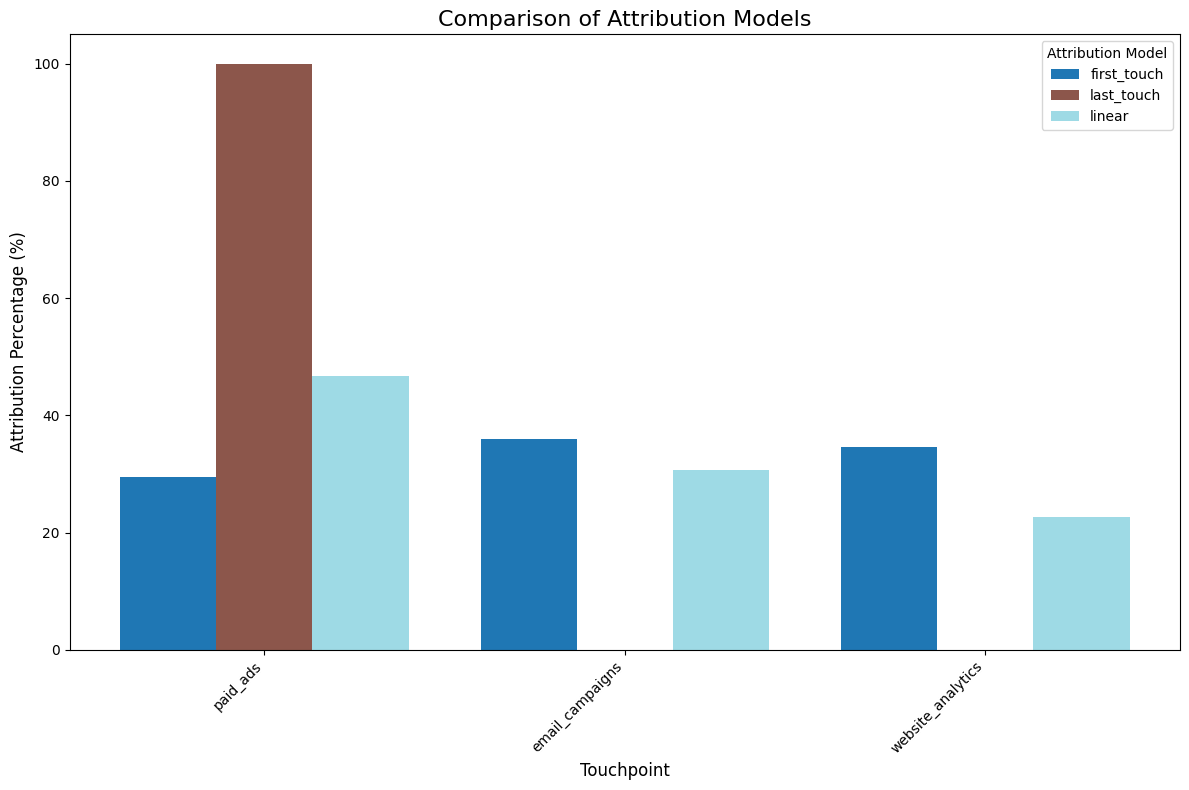

In [28]:
def example_usage():
    """Fixed example usage with visualization fixes."""
    import os
    import pandas as pd

    # Initialize the system
    attribution_system = MarketingAttribution()

    # 1. Data ingestion
    print("Ingesting data...")
    attribution_system.data_ingestion.ingest_csv(
        name='website_analytics',
        file_path='simulated_data/website_analytics.csv'
    )

    attribution_system.data_ingestion.ingest_csv(
        name='email_campaigns',
        file_path='simulated_data/email_campaigns.csv'
    )

    attribution_system.data_ingestion.ingest_csv(
        name='paid_ads',
        file_path='simulated_data/paid_ads.csv'
    )

    # 2. Unify customer data
    print("Unifying customer data...")
    unified_data = attribution_system.data_ingestion.unify_customer_data(
        id_mapping_columns={
            'website_analytics': 'user_id',
            'email_campaigns': 'email_id',
            'paid_ads': 'click_id'
        },
        timestamp_columns={
            'website_analytics': 'timestamp',
            'email_campaigns': 'date',
            'paid_ads': 'click_time'
        },
        conversion_column='purchase'
    )

    # Use pre-generated unified data if needed
    if unified_data is None:
        print("Using pre-generated unified data...")
        try:
            # Load pre-generated unified data
            pre_unified = pd.read_csv('simulated_data/unified_data.csv')
            pre_unified['timestamp'] = pd.to_datetime(pre_unified['timestamp'])
            pre_unified['is_conversion'] = pre_unified['is_conversion'].astype(bool)

            # Set the data directly
            attribution_system.customer_journey.set_data(pre_unified)
            unified_data = pre_unified
            print(f"Successfully set pre-unified data with {len(pre_unified)} records")
        except Exception as e:
            print(f"Error loading pre-unified data: {str(e)}")
            return

    # 3. Create customer journeys
    print("Creating customer journeys...")
    journeys = attribution_system.customer_journey.create_customer_journeys(
        customer_id_col='customer_id',
        timestamp_col='timestamp',
        channel_col='data_source',
        conversion_col='is_conversion'
    )

    # 4. If the system's method fails, use manual journey creation
    if not journeys:
        print("Using manual journey creation...")
        journeys = manual_customer_journey_creation(unified_data)

        # Apply visualization fixes
        fix_visualization_issues(attribution_system, journeys)

    # 5. Add funnel stages
    attribution_system.customer_journey.add_funnel_stages({
        'website_analytics': 'awareness',
        'email_campaigns': 'consideration',
        'paid_ads': 'conversion'
    })

    # 6. Run attribution models
    print("Running attribution models...")
    try:
        attribution_results = attribution_system.run_attribution_models([
            'first_touch',
            'last_touch',
            'linear'
        ])
        print("Attribution models completed successfully")
    except Exception as e:
        print(f"Error running attribution models: {str(e)}")

    # 7. Create visualizations
    print("Creating visualizations...")
    output_dir = 'attribution_results'
    os.makedirs(output_dir, exist_ok=True)

    try:
        # Fix the visualization format issue - Use .png instead of .html for matplotlib figures
        visualizations = attribution_system.create_visualizations(
            visualizations=[
                'customer_journey'  # Use only plotly-based visualizations first
            ],
            output_dir=output_dir
        )
        print("Customer journey visualization created successfully")

        # Try matplotlib-based visualizations with correct format
        try:
            # Create a separate directory for matplotlib figures
            matplotlib_dir = os.path.join(output_dir, 'matplotlib')
            os.makedirs(matplotlib_dir, exist_ok=True)

            # Try attribution comparison with PNG format
            save_path = os.path.join(matplotlib_dir, 'attribution_comparison.png')
            fig = attribution_system.visualization.plot_attribution_comparison(save_path=save_path)
            print("Attribution comparison visualization created successfully")
        except Exception as e:
            print(f"Error creating matplotlib visualization: {str(e)}")

    except Exception as e:
        print(f"Error creating visualizations: {str(e)}")

    # 8. Generate report
    try:
        report = attribution_system.generate_report(
            output_path=f"{output_dir}/attribution_report.html"
        )
        print("Report generated successfully")
    except Exception as e:
        print(f"Error generating report: {str(e)}")

    print(f"Marketing attribution analysis completed. Results saved to {output_dir}")
    return attribution_system
if __name__ == "__main__":
    example_usage()